# 1. Import Dependencies

In [72]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable 

from neuralprophet import NeuralProphet

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdate
import seaborn as sns

import pandas as pd
import datetime as dt
import requests

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr as PCC

print("All libraries loaded")

All libraries loaded


# 2. Download Data

In [3]:
def download_data(url, name='', usecols=None, sheet_name=1, header=2, plot=False): 
    global config
    
    r = requests.get(url)
    open('temp.xls', 'wb').write(r.content)
    df = pd.read_excel('temp.xls', sheet_name=sheet_name, header=header, usecols=usecols) 
    df = df[~df.isnull().any(axis=1)] # remove rows with any missing data
       
    num_data_points = len(df)
    
    df2 = df.iloc[[0, -1]]    
    date_range = "from " + str(df2.iloc[0,0]) + " to " + str(df2.iloc[1,0])
    print(date_range, str(num_data_points) + ' Data Points')
    
    data_dict = {}
    data_dict['data'] = df.rename(columns={df.keys()[0]: 'date', 
                            df.keys()[1]: name})
    data_dict['num elements'] = num_data_points
    data_dict['date range'] = date_range
    data_dict['name'] = df.keys()[1]
    
    if plot:
        fig = figure(figsize=(25, 5), dpi=80)
        fig.patch.set_facecolor((1.0, 1.0, 1.0))
        plt.plot(data_dict['data']['date'], data_dict['data'][name], color=config["plots"]["color_actual"])
        plt.title(data_dict['name'] + ", " + data_dict['date range'] + ", " + str(data_dict['num elements']) + " Data Points")

        # Format the x axis
        locator = mdate.MonthLocator(interval=config["plots"]["xticks_interval"])
        fmt = mdate.DateFormatter('%Y-%m')
        X = plt.gca().xaxis
        X.set_major_locator(locator)
        # Specify formatter
        X.set_major_formatter(fmt)
        plt.xticks(rotation='vertical')
        plt.xlim([data_dict['data'].iloc[0,0], data_dict['data'].iloc[-1,0]])

        plt.grid(visible=None, which='major', axis='y', linestyle='--')
        plt.show()
         
    return data_dict

In [4]:
plot = False

## 2a. Seattle Gas Prices (targets)

In [5]:
seattle_gas_prices = download_data('https://www.eia.gov/dnav/pet/hist_xls/EMM_EPMRU_PTE_Y48SE_DPGw.xls', 
                                   name='gas price',
                                  plot=plot)

print(seattle_gas_prices['data'].head())

from 2003-05-26 00:00:00 to 2022-07-04 00:00:00 998 Data Points
        date  gas price
0 2003-05-26      1.534
1 2003-06-02      1.524
2 2003-06-09      1.522
3 2003-06-16      1.578
4 2003-06-23      1.580


## 2b. U.S. Crude Oil Stock Change (feature 1)

In [6]:
us_oil_stock = download_data('https://www.eia.gov/dnav/pet/hist_xls/MCRSCUS1m.xls',
                             name='oil stock exchange',
                             plot=plot)

print(us_oil_stock['data'].head())

from 1981-01-15 00:00:00 to 2022-04-15 00:00:00 496 Data Points
        date  oil stock exchange
0 1981-01-15               -1535
1 1981-02-15                7773
2 1981-03-15               19596
3 1981-04-15               17853
4 1981-05-15               12109


## 2c. U.S. Natural Gas Rotary Rigs in Operation (feature 2)

In [7]:
us_drilling_activity = download_data('https://www.eia.gov/dnav/pet/hist_xls/E_ERTRRG_XR0_NUS_Cm.xls',
                             name='drilling activity',
                             plot=plot)

print(us_drilling_activity['data'].head())

from 1987-08-15 00:00:00 to 2022-03-15 00:00:00 416 Data Points
          date  drilling activity
175 1987-08-15              352.0
176 1987-09-15              364.0
177 1987-10-15              377.0
178 1987-11-15              386.0
179 1987-12-15              403.0


## 2d. U.S. Natural Gas Production (feature 3)

In [8]:
us_gas_production = download_data('https://www.eia.gov/dnav/ng/hist_xls/N9050US2m.xls',
                             name='gas production',
                             plot=plot)

print(us_gas_production['data'].head())

from 1973-01-15 00:00:00 to 2022-04-15 00:00:00 592 Data Points
        date  gas production
0 1973-01-15         1948000
1 1973-02-15         1962000
2 1973-03-15         1907000
3 1973-04-15         1814000
4 1973-05-15         1898000


## 2e. U.S. Natural Gas Consumption (feature 4)

In [9]:
us_gas_consumption = download_data('https://www.eia.gov/dnav/ng/hist_xls/N9140US2m.xls',
                             name='gas consumption',
                             plot=plot)

print(us_gas_consumption['data'].head())

from 2001-01-15 00:00:00 to 2022-04-15 00:00:00 256 Data Points
        date  gas consumption
0 2001-01-15          2676998
1 2001-02-15          2309464
2 2001-03-15          2246633
3 2001-04-15          1807170
4 2001-05-15          1522382


## 2f. Underground Natural Gas Storage Capacity (feature 5)

In [10]:
us_gas_storage = download_data('https://www.eia.gov/dnav/ng/xls/NG_STOR_CAP_DCU_NUS_M.xls',
                             name='gas storage',
                               usecols='A:B',
                             plot=plot)

print(us_gas_storage['data'].head())

from 1989-01-15 00:00:00 to 2022-04-15 00:00:00 400 Data Points
        date  gas storage
0 1989-01-15      8119368
1 1989-02-15      8119368
2 1989-03-15      8119368
3 1989-04-15      8119368
4 1989-05-15      8119368


## 2g. U.S. Natural Gas Import Volumes (feature 6)

In [11]:
us_gas_import_volume = download_data('https://www.eia.gov/dnav/ng/xls/NG_MOVE_IMPC_S1_M.xls',
                             name='gas import volume',
                               usecols='A:B',
                               sheet_name=1,
                             plot=plot)

print(us_gas_import_volume['data'].head())

from 1973-01-15 00:00:00 to 2022-04-15 00:00:00 592 Data Points
        date  gas import volume
0 1973-01-15              92694
1 1973-02-15              83870
2 1973-03-15              91581
3 1973-04-15              88407
4 1973-05-15              85844


## 2g. U.S. Natural Gas Import Prices (feature 7)

In [12]:
us_gas_import_price = download_data('https://www.eia.gov/dnav/ng/xls/NG_MOVE_IMPC_S1_M.xls',
                             name='gas import price',
                               usecols='A:B',
                               sheet_name=2,
                             plot=plot)

print(us_gas_import_price['data'].head())

from 1989-01-15 00:00:00 to 2022-04-15 00:00:00 400 Data Points
        date  gas import price
0 1989-01-15              1.72
1 1989-02-15              1.88
2 1989-03-15              1.81
3 1989-04-15              1.73
4 1989-05-15              1.76


## 2h. Henry Hub Natural Gas Spot Price (feature 8)

In [13]:
hh_natural_gas_price = download_data('https://www.eia.gov/dnav/ng/hist_xls/RNGWHHDm.xls',
                             name='natural gas price',
                             plot=plot)

print(hh_natural_gas_price['data'].head())

from 1997-01-15 00:00:00 to 2022-06-15 00:00:00 306 Data Points
        date  natural gas price
0 1997-01-15               3.45
1 1997-02-15               2.15
2 1997-03-15               1.89
3 1997-04-15               2.03
4 1997-05-15               2.25


## 2i. Crude Oil Sport Price (feature 9)

In [14]:
us_crude_oil_price = download_data('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_M.xls',
                                   name='crude oil price',
                                   usecols='A:B',
                                   sheet_name=1, 
                                   plot=plot)

print(us_crude_oil_price['data'].head())

from 1986-01-15 00:00:00 to 2022-06-15 00:00:00 438 Data Points
        date  crude oil price
0 1986-01-15            22.93
1 1986-02-15            15.46
2 1986-03-15            12.61
3 1986-04-15            12.84
4 1986-05-15            15.38


## 2j. Conventional Gasoline Price (feature 10)

In [15]:
us_gas_price = download_data('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_M.xls',
                                   name='conventional gas price',
                                   usecols='A:B',
                                   sheet_name=2, 
                                   plot=plot)

print(us_gas_price['data'].head())

from 1986-06-15 00:00:00 to 2022-06-15 00:00:00 433 Data Points
        date  conventional gas price
0 1986-06-15                   0.420
1 1986-07-15                   0.340
2 1986-08-15                   0.426
3 1986-09-15                   0.420
4 1986-10-15                   0.410


## 2k. RBOB Gasoline Price (feature 11)

In [16]:
us_rbob_price = download_data('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_M.xls',
                                   name='rbob gas price',
                                   usecols='A:B',
                                   sheet_name=3, 
                                   plot=plot)

print(us_rbob_price['data'].head())

from 2003-06-15 00:00:00 to 2022-06-15 00:00:00 229 Data Points
        date  rbob gas price
0 2003-06-15           1.072
1 2003-07-15           0.965
2 2003-08-15           1.315
3 2003-09-15           0.949
4 2003-10-15           0.996


## 2l. Heating Oil Price (feature 12)

In [17]:
us_heating_oil_price = download_data('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_M.xls',
                                   name='heating oil price',
                                   usecols='A:B',
                                   sheet_name=4, 
                                   plot=plot)

print(us_heating_oil_price['data'].head())

from 1986-06-15 00:00:00 to 2022-06-15 00:00:00 433 Data Points
        date  heating oil price
0 1986-06-15              0.380
1 1986-07-15              0.334
2 1986-08-15              0.408
3 1986-09-15              0.402
4 1986-10-15              0.394


## 2m. Diesel Price (feature 13)

In [18]:
us_diesel_price = download_data('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_M.xls',
                                   name='diesel price',
                                   usecols='A:B',
                                   sheet_name=5, 
                                   plot=plot)

print(us_diesel_price['data'].head())

from 2006-06-15 00:00:00 to 2022-06-15 00:00:00 193 Data Points
          date  diesel price
122 2006-06-15         2.091
123 2006-07-15         2.217
124 2006-08-15         2.247
125 2006-09-15         1.810
126 2006-10-15         1.794


## 2n. Kerosene Price (feature 14)

In [19]:
us_kerosene_price = download_data('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_M.xls',
                                   name='kerosene price',
                                   usecols='A:B',
                                   sheet_name=6, 
                                   plot=plot)

print(us_kerosene_price['data'].head())

from 1990-04-15 00:00:00 to 2022-06-15 00:00:00 387 Data Points
        date  kerosene price
0 1990-04-15           0.540
1 1990-05-15           0.515
2 1990-06-15           0.494
3 1990-07-15           0.535
4 1990-08-15           0.791


## 2o. Propane Price (feature 15)

In [20]:
us_propane_price = download_data('https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_M.xls',
                                   name='propane price',
                                   usecols='A:B',
                                   sheet_name=7, 
                                   plot=plot)

print(us_propane_price['data'].head())

from 1992-06-15 00:00:00 to 2022-06-15 00:00:00 361 Data Points
        date  propane price
0 1992-06-15          0.344
1 1992-07-15          0.342
2 1992-08-15          0.354
3 1992-09-15          0.375
4 1992-10-15          0.354


# 3. Combine Feature and Target Data

In [116]:
# features
feature_list = [
    hh_natural_gas_price['data'],
    us_crude_oil_price['data'],
    us_gas_price['data'],
    us_rbob_price['data'],
    us_heating_oil_price['data'],
    us_diesel_price['data'],
    us_kerosene_price['data'],
    us_propane_price['data'],
    us_oil_stock['data'],
    us_drilling_activity['data'],
    us_gas_production['data'],
    us_gas_consumption['data'],
    us_gas_storage['data'],
    us_gas_import_volume['data'],
    us_gas_import_price['data']
]

# targets
targets = seattle_gas_prices['data'].set_index('date')

,crude oil price,conventional gas price,rbob gas price,heating oil price,diesel price,kerosene price,propane price,oil stock exchange,drilling activity,gas production,gas consumption,gas storage,gas import volume,gas import price,week number,gas price
2006-06-19,71.411333,2.087933,2.412600,1.926333,2.107800,2.090733,1.106067,-4598.933333,1376.400000,1.618895e+06,1.578593e+06,8.247523e+06,351139.000000,5.846000,25.0,3.067
2006-06-26,72.218667,2.128067,2.432900,1.928667,2.137200,2.107767,1.121933,-4744.066667,1377.100000,1.627353e+06,1.627092e+06,8.249157e+06,356466.000000,5.874000,26.0,3.027
2006-07-03,73.026000,2.168200,2.453200,1.931000,2.166600,2.124800,1.137800,-4889.200000,1377.800000,1.635812e+06,1.675591e+06,8.250790e+06,361793.000000,5.902000,27.0,3.004
2006-07-10,73.833333,2.208333,2.473500,1.933333,2.196000,2.141833,1.153667,-5034.333333,1378.500000,1.644271e+06,1.724091e+06,8.252423e+06,367120.000000,5.930000,28.0,3.032
2006-07-17,74.321613,2.224161,2.468774,1.938161,2.218935,2.152645,1.163258,-4727.161290,1381.451613,1.650682e+06,1.758278e+06,8.253590e+06,370540.935484,6.000968,29.0,3.018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-06,113.304194,4.008258,4.201484,4.318871,4.444452,4.056710,1.220161,-13469.000000,135.000000,3.134567e+06,2.357870e+06,9.258914e+06,246576.000000,5.460000,23.0,5.416
2022-06-13,114.498710,4.065613,4.254774,4.262194,4.380323,4.105935,1.219258,-13469.000000,135.000000,3.134567e+06,2.357870e+06,9.258914e+06,246576.000000,5.460000,24.0,5.549
2022-06-20,114.840000,4.082000,4.270000,4.246000,4.362000,4.120000,1.219000,-13469.000000,135.000000,3.134567e+06,2.357870e+06,9.258914e+06,246576.000000,5.460000,25.0,5.518
2022-06-27,114.840000,4.082000,4.270000,4.246000,4.362000,4.120000,1.219000,-13469.000000,135.000000,3.134567e+06,2.357870e+06,9.258914e+06,246576.000000,5.460000,26.0,5.461


In [ ]:
# reindex and concatenate features
kw = dict(method="time")
for i in range(0, len(feature_list)):
    if i > 1:
        feature = feature_list[i].set_index('date')
        feature = feature.reindex(feature.index.union(targets.index)).interpolate(**kw).reindex(targets.index)
        features = features.join(feature)
    else:
        feature = pd.DataFrame(feature_list[i]).set_index('date')
        features = feature.reindex(feature.index.union(targets.index)).interpolate(**kw).reindex(targets.index)  

# add week number (1-52) as a feature
features['week number'] = features.index.isocalendar().week
features['week number'] = features['week number'].astype(float)
    
# combine features and targets into one data frame
features_targets = features.join(targets)

# get rid of rows with any missing data
features_targets = features_targets[~features_targets.isnull().any(axis=1)]

# convert index datetimes to dates (exclude hour, minute, second)
features_targets.index = features_targets.index.date
features_targets

# 4. Data Preprocessing

In [89]:
data = features_targets
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # training device
timesteps = 10 # lookback window
n_timeseries = data.shape[1] - 1 # input size
batch_size = 16
target = 'gas price' # target variable name

## 4a. Incorporate Rolling Lookback Window

In [90]:
# Preallocate feature and target arrays
X = np.zeros((len(data), timesteps, data.shape[1]-1))
y = np.zeros((len(data), timesteps, 1))

In [91]:
for i, name in enumerate(list(data.columns[:-1])):
    for j in range(timesteps):
        X[:, j, i] = data[name].shift(timesteps - j - 1).fillna(method="bfill")

In [92]:
for j in range(timesteps):
    y[:, j, 0] = data[target].shift(timesteps - j - 1).fillna(method="bfill")

In [93]:
prediction_horizon = 1
target = data[target].shift(-prediction_horizon).fillna(method="ffill").values

## 4b. Build Training, Validation, and Testing Datasets

In [94]:
# Dataset indices
up_to_train_idx = int(data.shape[0]*0.70)
up_to_val_idx = int(data.shape[0]*0.85)

# Number of data points in each dataset
train_length = up_to_train_idx
val_length = up_to_val_idx - up_to_train_idx
test_length = data.shape[0] - train_length - val_length

print(train_length, val_length, test_length)

586 126 126


In [95]:
X = X[timesteps:]
y = y[timesteps:]
target = target[timesteps:]

In [96]:
X_train = X[:train_length]
y_his_train = y[:train_length]
X_val = X[train_length:train_length+val_length]
y_his_val = y[train_length:train_length+val_length]
X_test = X[-val_length:]
y_his_test = y[-val_length:]
target_train = target[:train_length]
target_val = target[train_length:train_length+val_length]
target_test = target[-val_length:]

## 4c. Normalize Data

In [97]:
class Normalizer():
    def __init__(self):
        self.max = None
        self.min = None
        self.range = None

    def fit_transform(self, x):
        self.max = x.max(axis=0)
        self.min = x.min(axis=0)
        self.range = self.max - self.min
        normalized_x = (x - self.min)/self.range
        return normalized_x
    
    def transform(self, x):
        return (x - self.min)/self.range

    def inverse_transform(self, x):
        return (x*self.range) + self.min

In [98]:
x_scaler = Normalizer()
y_his_scaler = Normalizer()
target_scaler = Normalizer()

In [99]:
X_train = x_scaler.fit_transform(X_train)
X_val = x_scaler.transform(X_val)
X_test = x_scaler.transform(X_test)

y_his_train = y_his_scaler.fit_transform(y_his_train)
y_his_val = y_his_scaler.transform(y_his_val)
y_his_test = y_his_scaler.transform(y_his_test)

target_train = target_scaler.fit_transform(target_train)
target_val = target_scaler.transform(target_val)
target_test = target_scaler.transform(target_test)

## 4d. Build Torch Data Loaders

In [100]:
X_train_t = torch.Tensor(X_train)
X_val_t = torch.Tensor(X_val)
X_test_t = torch.Tensor(X_test)
y_his_train_t = torch.Tensor(y_his_train)
y_his_val_t = torch.Tensor(y_his_val)
y_his_test_t = torch.Tensor(y_his_test)
target_train_t = torch.Tensor(target_train)
target_val_t = torch.Tensor(target_val)
target_test_t = torch.Tensor(target_test)

In [101]:
data_train_loader = DataLoader(TensorDataset(X_train_t, y_his_train_t, target_train_t), shuffle=True, batch_size=batch_size)
data_val_loader = DataLoader(TensorDataset(X_val_t, y_his_val_t, target_val_t), shuffle=False, batch_size=batch_size)
data_test_loader = DataLoader(TensorDataset(X_test_t, y_his_test_t, target_test_t), shuffle=False, batch_size=batch_size)

# 6. Modeling

In [33]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [ ]:
def eval_plot():
    

In [ ]:
def nn_train(model, model_name, epochs, data_train_loader, data_val_loader, opt, scheduler, plot=True):
    
    loss = nn.MSELoss()

    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=50, verbose=True, path=f'{model_name}.pt') 

    for i in range(epochs):
        mse_train = 0

        for batch_x, batch_y_h, batch_y in data_train_loader :

            batch_x = batch_x.to(device)  
            batch_y = batch_y.to(device)
            batch_y_h = batch_y_h.to(device)
            opt.zero_grad()
            
            if model_name == 'lstm':
                h, c = model.init_hidden_internal(batch_x.shape[0])
                y_pred, h, c = model(batch_x, h, c)
            else:
                y_pred = model(batch_x, batch_y_h)

            y_pred = y_pred.squeeze(1)        
            l = loss(y_pred, batch_y)
            l.backward()
            mse_train += l.item()*batch_x.shape[0]
            opt.step()

        with torch.no_grad():
            mse_val = 0
            preds = []
            true = []
            for batch_x, batch_y_h, batch_y in data_val_loader:

                batch_x = batch_x.to(device)
                batch_y = batch_y.to(device)
                batch_y_h = batch_y_h.to(device)
                
                if model_name == 'lstm':
                    h, c = model.init_hidden_internal(batch_x.shape[0])
                    output, h, c = model(batch_x, h, c)
                else:
                    output = model(batch_x, batch_y_h)

                output = output.squeeze(1)
                preds.append(output.detach().cpu().numpy())
                true.append(batch_y.detach().cpu().numpy())
                mse_val += loss(output, batch_y).item()*batch_x.shape[0]
                
        preds = np.concatenate(preds)
        true = np.concatenate(true)

        # Learning rate scheduler
        scheduler.step(mse_val/len(X_val_t))
        lr = opt.param_groups[0]['lr']

        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(mse_val/len(X_val_t), model)

        if early_stopping.early_stop:
            print("Early stopping")
            break

        print("Iter: ", i, "train: ", (mse_train/len(X_train_t))**0.5, 
              "val: ", (mse_val/len(X_val_t))**0.5, 
              "LR: ", lr
             )
        if (plot == True) and (i % 10 == 0):
            preds = preds*(target_train_max - target_train_min) + target_train_min
            true = true*(target_train_max - target_train_min) + target_train_min
            mse = mean_squared_error(true, preds)
            mae = mean_absolute_error(true, preds)
            print("mse: ", mse, "mae: ", mae)
            plt.figure(figsize=(20, 10))
            plt.plot(preds)
            plt.plot(true)
            plt.show()
    return

In [ ]:
def nn_eval():
    

In [ ]:
def nn_forecast():

## 6a. Time Series Model (Neural Prophet)

### Training

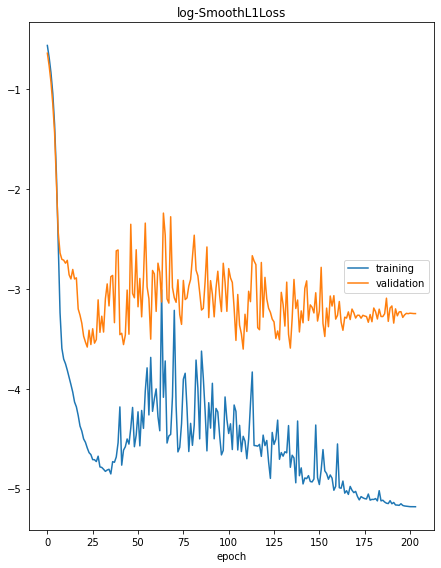

log-SmoothL1Loss
	training         	 (min:   -5.181, max:   -0.562, cur:   -5.181)
	validation       	 (min:   -3.603, max:   -0.640, cur:   -3.247)


In [34]:
data = seattle_gas_prices
df = data['data'].set_axis(['ds', 'y'], axis=1, inplace=False)

# https://rdrr.io/github/AlbertoAlmuinha/neuralprophet/man/neural_prophet.html
params = {
    # "seasonality_mode": "additive", 
    # "learning_rate": 0.1,
    # "n_changepoints": 40, # 48
    # "changepoints_range": 0.95, 
    # "trend_reg": 1,
    # "num_hidden_layers": 2,
    # "d_hidden": 64,
    # "yearly_seasonality": True, # True
    # "weekly_seasonality": False,
    # "daily_seasonality": False,
    # "loss_func": 'MSE',
    # "n_lags": 12,
    # "user_changepoints", 
}

model = NeuralProphet(**params)

df_train, df_test = model.split_df(df=df, freq="W", valid_p=0.15)

metrics =  model.fit(df_train, freq="W", validation_df=df_test, progress="plot")

In [35]:
metrics.tail(1)

,SmoothL1Loss,MAE,RMSE,RegLoss,SmoothL1Loss_val,MAE_val,RMSE_val
203,0.005622,0.197542,0.2598,0.0,0.038893,0.585821,0.707293


### Evaluation

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.329% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.329% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.329% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.forecaster._evaluate) - Validation metrics:    SmoothL1Loss    MAE   RMSE
1         0.039  0.586  0.707


   SmoothL1Loss       MAE      RMSE
0      0.038893  0.585821  0.707293


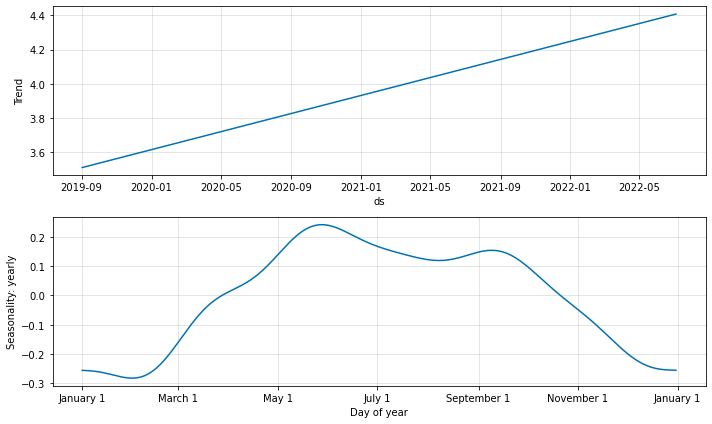

In [36]:
test_pred = model.predict(df_test)
test_components = model.plot_components(test_pred)

test_metrics = model.test(df_test)
print(test_metrics)

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.9% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.9% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


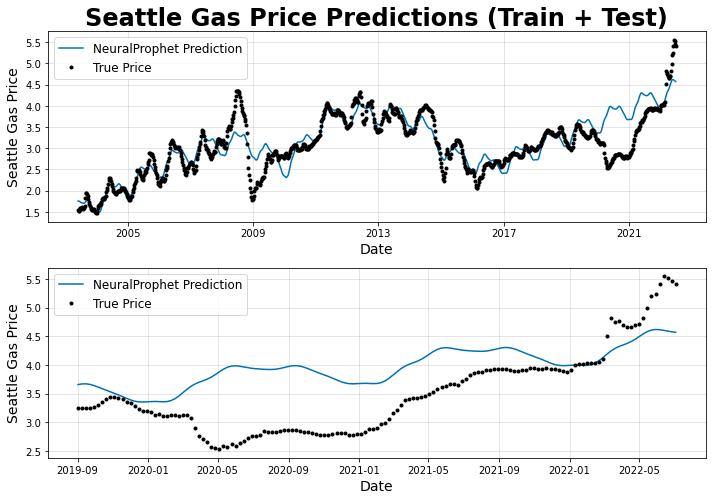

In [37]:
# fig, ax = plt.subplots(figsize=(10, 7))
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7), sharex=False)
model.plot(model.predict(df), ax=ax1)
ax1.set_xlabel('Date', fontsize=14)
ax1.set_ylabel('Seattle Gas Price', fontsize=14)
ax1.set_title("Seattle Gas Price Predictions (Train + Test)", fontsize=24, fontweight="bold")
ax1.legend(labels=['NeuralProphet Prediction', 'True Price'], fontsize=12)

# fig, ax = plt.subplots(figsize=(10, 7))
model.plot(test_pred, xlabel='Date', ylabel='Seattle Gas Price', ax=ax2)
ax2.set_xlabel('Date', fontsize=14)
ax2.set_ylabel('Seattle Gas Price', fontsize=14)
ax2.legend(labels=['NeuralProphet Prediction', 'True Price'], fontsize=12)

### Forecasting

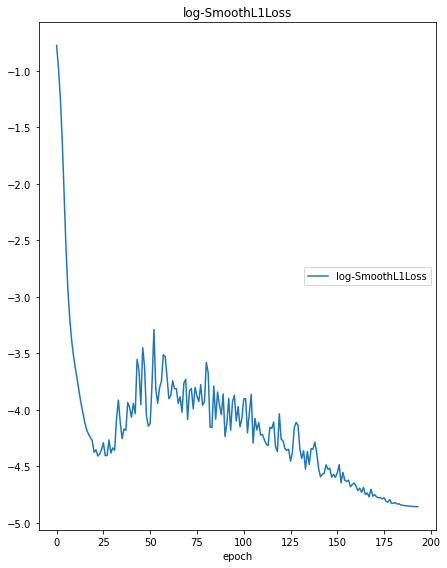

log-SmoothL1Loss
	log-SmoothL1Loss 	 (min:   -4.857, max:   -0.775, cur:   -4.857)


In [38]:
model2 = NeuralProphet(**params)
metrics_train2 = model2.fit(df=df, freq="W", progress="plot")

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.9% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.9% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W


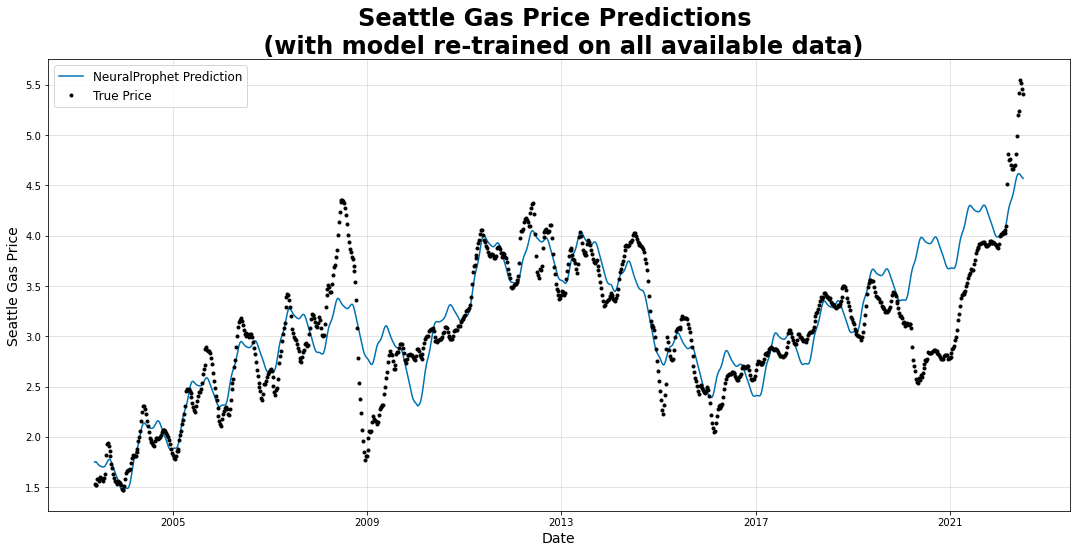

In [39]:
# fig = model.plot(model2.predict(df))
fig, ax = plt.subplots(figsize=(15, 7))
model.plot(model.predict(df), ax=ax)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Seattle Gas Price', fontsize=14)
ax.set_title("Seattle Gas Price Predictions \n (with model re-trained on all available data)", fontsize=24, fontweight="bold")
ax.legend(labels=['NeuralProphet Prediction', 'True Price'], fontsize=12)

In [40]:
future = model2.make_future_dataframe(df, periods=12, n_historic_predictions=96)
forecast = model2.predict(future)

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 99.9% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
WARNING - (py.warnings._showwarnmsg) - C:\Users\cpras\anaconda3\envs\GasPrice\lib\site-packages\neuralprophet\forecaster.py:2060: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(future_df)

INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.148% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-MON corresponds to 98.148% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
WARNING - (py.warnings._showwarnmsg) - C:\Users\cpras\anaconda3\envs\GasPrice\lib\site-packages\neuralprophet\forecaster.py:1406: FutureWarning: T

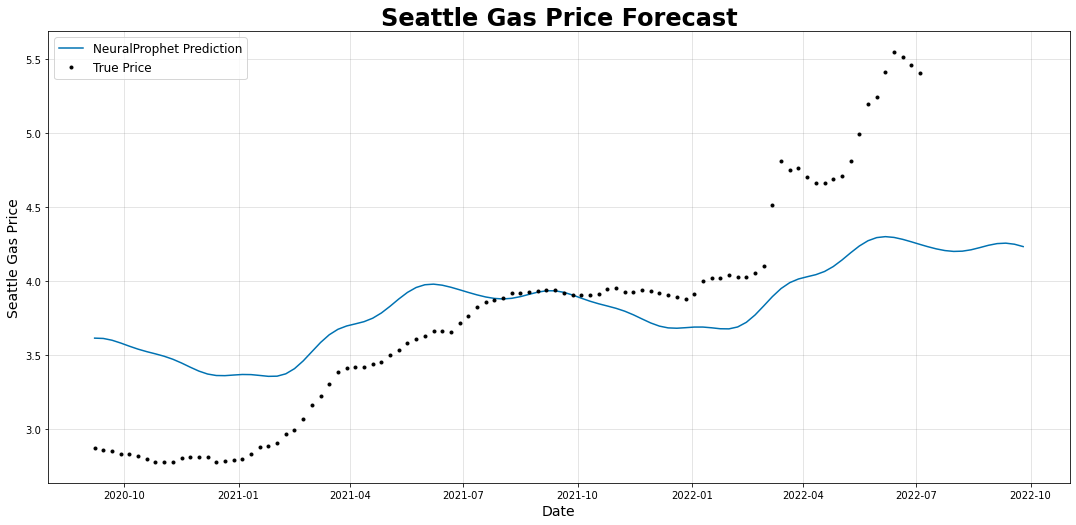

In [41]:
# fig = model2.plot(forecast)

fig, ax = plt.subplots(figsize=(15, 7))
model.plot(forecast, ax=ax)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Seattle Gas Price', fontsize=14)
ax.set_title("Seattle Gas Price Forecast", fontsize=24, fontweight="bold")
ax.legend(labels=['NeuralProphet Prediction', 'True Price'], fontsize=12)

## 6b. Neural Network (LSTM)

In [45]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length, dropout=0.1):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=dropout)
        
        self.fc = nn.Linear(hidden_size, num_classes)
        
        # Define activation function
        self.relu = nn.ReLU()

    def forward(self, x, h_0, c_0):
        
        # Propagate input through LSTM
        self.lstm.flatten_parameters()
        
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        out = self.relu(output[:,-1,:])
        out = self.fc(out) 
        
        return out, hn, cn
    
    def init_hidden_internal(self, batch_size):
        h_0 = Variable(torch.zeros(
            self.num_layers, batch_size, self.hidden_size)).to(device)
        
        c_0 = Variable(torch.zeros(
            self.num_layers, batch_size, self.hidden_size)).to(device)
        return h_0, c_0

### Training

In [102]:
lstm = LSTM(num_classes=1, input_size=n_timeseries, hidden_size=64, num_layers=2, # hidden=64, layers=2
             seq_length=timesteps, dropout=0.2)
opt = torch.optim.Adam(lstm.parameters(), lr=0.01)
epoch_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, patience=15)

Validation loss decreased (inf --> 0.007196).  Saving model ...
Iter:  0 train:  0.1471082043898761 val:  0.08483152624581855 LR:  0.01
mse:  0.047939178 mae:  0.17985994


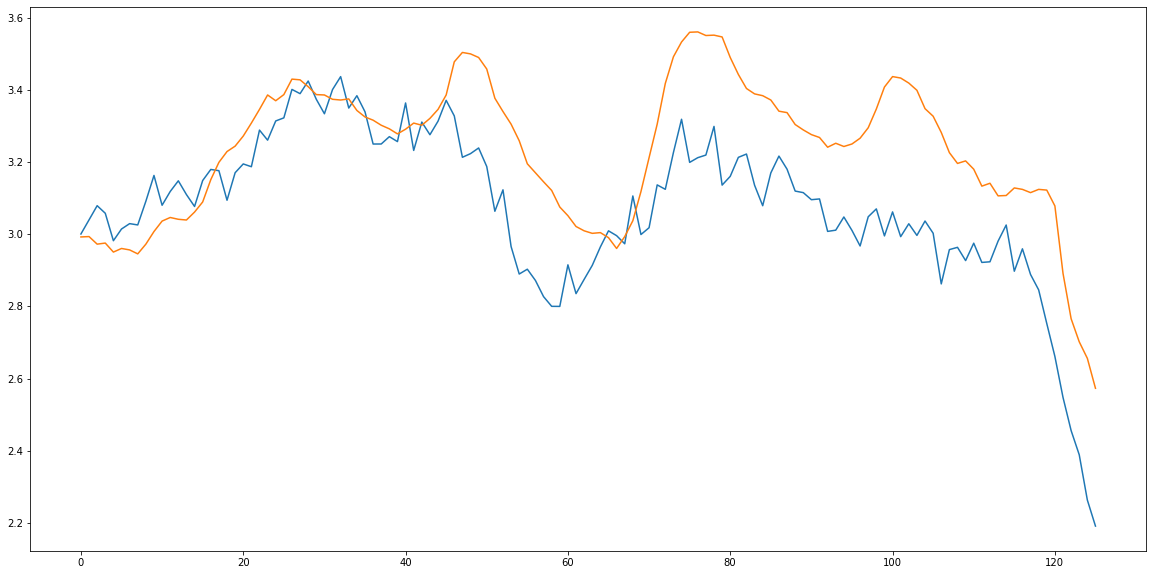

Validation loss decreased (0.007196 --> 0.006921).  Saving model ...
Iter:  1 train:  0.07107023592338328 val:  0.08319503287464441 LR:  0.01
EarlyStopping counter: 1 out of 50
Iter:  2 train:  0.06265338542006987 val:  0.14891080530383938 LR:  0.01
EarlyStopping counter: 2 out of 50
Iter:  3 train:  0.055618539434549204 val:  0.11261238177047164 LR:  0.01
EarlyStopping counter: 3 out of 50
Iter:  4 train:  0.05184780670143926 val:  0.11846457943176601 LR:  0.01
EarlyStopping counter: 4 out of 50
Iter:  5 train:  0.06533657707176023 val:  0.12461413751970833 LR:  0.01
EarlyStopping counter: 5 out of 50
Iter:  6 train:  0.04768352613183527 val:  0.1309982695530381 LR:  0.01
EarlyStopping counter: 6 out of 50
Iter:  7 train:  0.04849752253338833 val:  0.11006635451438954 LR:  0.01
EarlyStopping counter: 7 out of 50
Iter:  8 train:  0.0440806996110589 val:  0.09997572920017671 LR:  0.01
EarlyStopping counter: 8 out of 50
Iter:  9 train:  0.04281564353470389 val:  0.1001833334527264 LR:  0

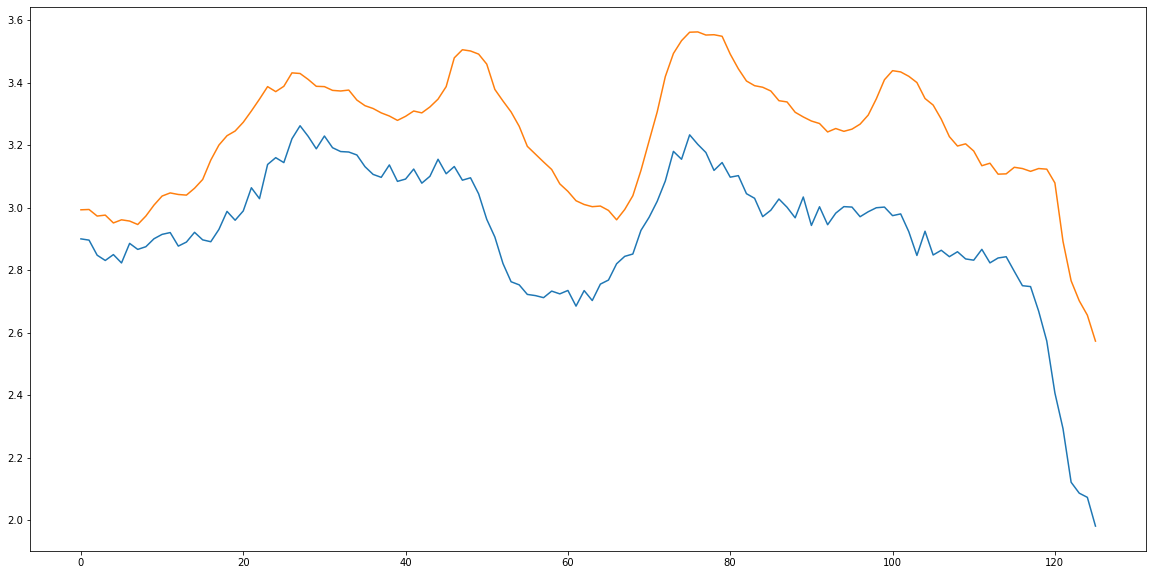

EarlyStopping counter: 10 out of 50
Iter:  11 train:  0.053353942929811965 val:  0.1244533286742361 LR:  0.01
EarlyStopping counter: 11 out of 50
Iter:  12 train:  0.058261939715721175 val:  0.11517662558157854 LR:  0.01
EarlyStopping counter: 12 out of 50
Iter:  13 train:  0.060983184351576104 val:  0.10790303349319132 LR:  0.01
EarlyStopping counter: 13 out of 50
Iter:  14 train:  0.0432546070403386 val:  0.08986225770118468 LR:  0.01
EarlyStopping counter: 14 out of 50
Iter:  15 train:  0.03988106340796502 val:  0.0997231244622295 LR:  0.01
EarlyStopping counter: 15 out of 50
Iter:  16 train:  0.0392156559699647 val:  0.08456057972921253 LR:  0.01
EarlyStopping counter: 16 out of 50
Iter:  17 train:  0.04421542916364072 val:  0.09270287242551722 LR:  0.001
EarlyStopping counter: 17 out of 50
Iter:  18 train:  0.03420797336684009 val:  0.10474399965233049 LR:  0.001
EarlyStopping counter: 18 out of 50
Iter:  19 train:  0.03214997285065986 val:  0.10536937051430749 LR:  0.001
EarlySto

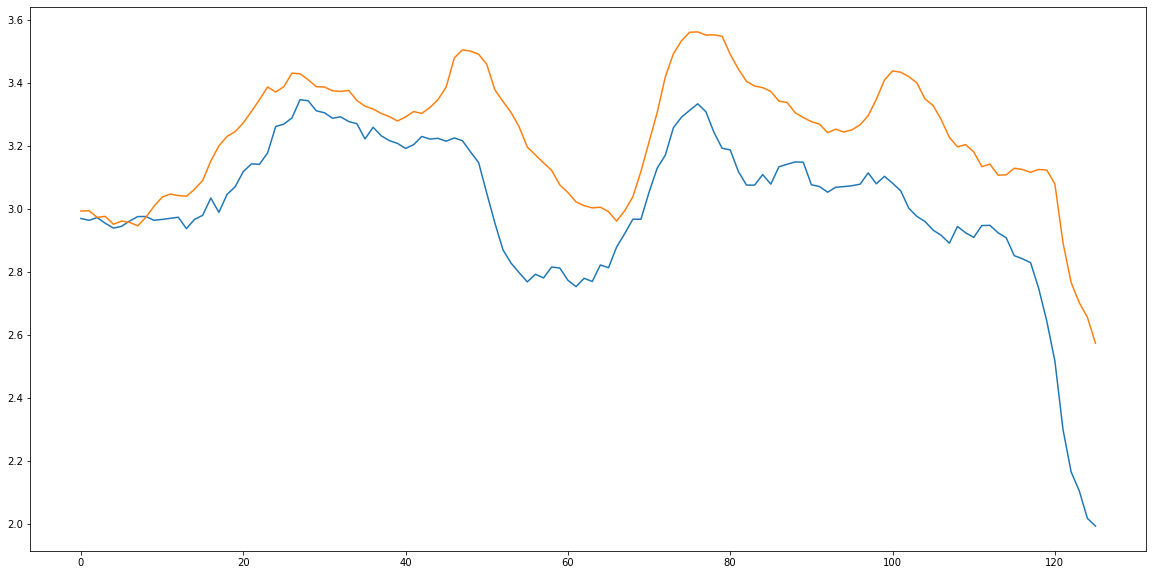

EarlyStopping counter: 20 out of 50
Iter:  21 train:  0.031182640657059772 val:  0.10179148269631877 LR:  0.001
EarlyStopping counter: 21 out of 50
Iter:  22 train:  0.030284546379831842 val:  0.10051102427145091 LR:  0.001
EarlyStopping counter: 22 out of 50
Iter:  23 train:  0.03114150434258471 val:  0.09939619441694088 LR:  0.001
EarlyStopping counter: 23 out of 50
Iter:  24 train:  0.030518671185444088 val:  0.10207640653610596 LR:  0.001
EarlyStopping counter: 24 out of 50
Iter:  25 train:  0.031220784332824828 val:  0.09909496176174976 LR:  0.001
EarlyStopping counter: 25 out of 50
Iter:  26 train:  0.0303393647028397 val:  0.1025976664481844 LR:  0.001
EarlyStopping counter: 26 out of 50
Iter:  27 train:  0.029542696854165534 val:  0.10029969761110133 LR:  0.001
EarlyStopping counter: 27 out of 50
Iter:  28 train:  0.02974839115961555 val:  0.10163167474218579 LR:  0.001
EarlyStopping counter: 28 out of 50
Iter:  29 train:  0.02899095907786042 val:  0.10602031554471661 LR:  0.00

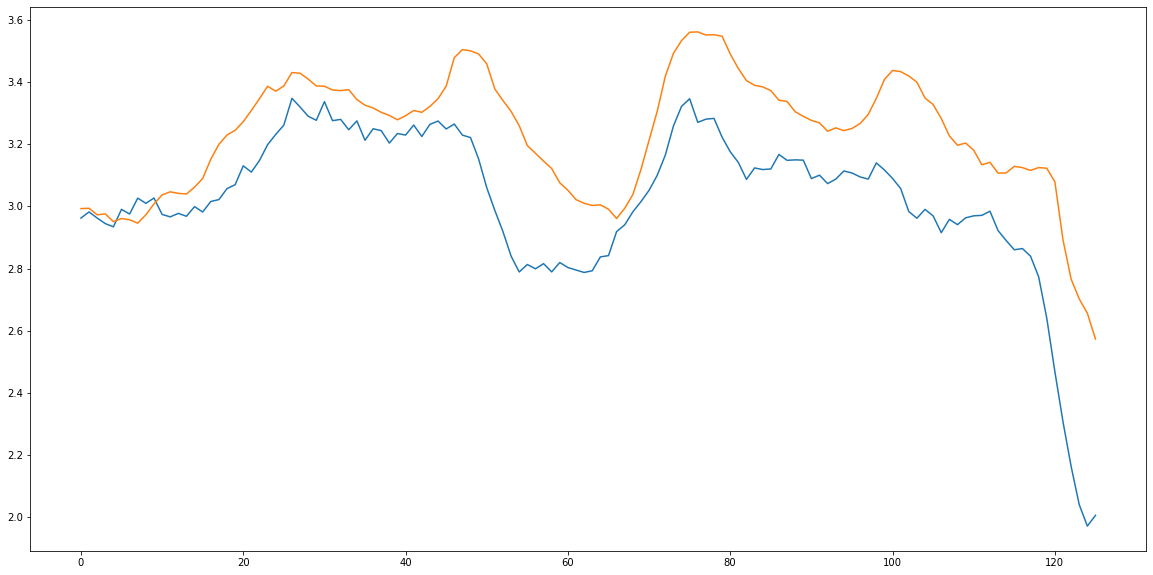

EarlyStopping counter: 30 out of 50
Iter:  31 train:  0.02915656731161059 val:  0.10441268202375656 LR:  0.001
EarlyStopping counter: 31 out of 50
Iter:  32 train:  0.028983679892828695 val:  0.09451843586244084 LR:  0.001
EarlyStopping counter: 32 out of 50
Iter:  33 train:  0.02973402704661935 val:  0.09277104770638629 LR:  0.0001
EarlyStopping counter: 33 out of 50
Iter:  34 train:  0.02938314588755985 val:  0.09787350421197065 LR:  0.0001
EarlyStopping counter: 34 out of 50
Iter:  35 train:  0.028516771087008203 val:  0.09927072456821426 LR:  0.0001
EarlyStopping counter: 35 out of 50
Iter:  36 train:  0.027971095651900705 val:  0.10031468710226692 LR:  0.0001
EarlyStopping counter: 36 out of 50
Iter:  37 train:  0.027295522635986273 val:  0.10083173913348853 LR:  0.0001
EarlyStopping counter: 37 out of 50
Iter:  38 train:  0.028008964456883553 val:  0.09904269463860721 LR:  0.0001
EarlyStopping counter: 38 out of 50
Iter:  39 train:  0.027708988548593858 val:  0.10064256735506101 

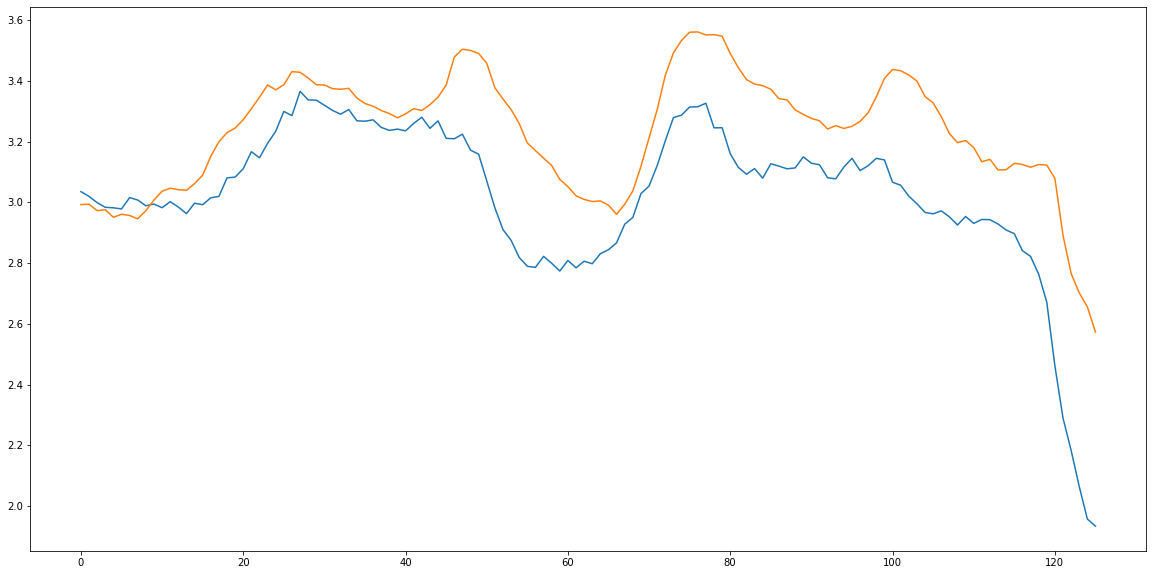

EarlyStopping counter: 40 out of 50
Iter:  41 train:  0.027089546694289965 val:  0.10014254943774556 LR:  0.0001
EarlyStopping counter: 41 out of 50
Iter:  42 train:  0.02818475028680753 val:  0.09990690531845804 LR:  0.0001
EarlyStopping counter: 42 out of 50
Iter:  43 train:  0.02760189106577639 val:  0.09899605823554626 LR:  0.0001
EarlyStopping counter: 43 out of 50
Iter:  44 train:  0.027957735563537704 val:  0.10073340418212598 LR:  0.0001
EarlyStopping counter: 44 out of 50
Iter:  45 train:  0.02690497212180701 val:  0.09991951766875758 LR:  0.0001
EarlyStopping counter: 45 out of 50
Iter:  46 train:  0.028307270070554277 val:  0.10030250633086449 LR:  0.0001
EarlyStopping counter: 46 out of 50
Iter:  47 train:  0.027894017884934404 val:  0.10006173992549786 LR:  0.0001
EarlyStopping counter: 47 out of 50
Iter:  48 train:  0.027653873887831214 val:  0.10086369854699036 LR:  0.0001
EarlyStopping counter: 48 out of 50
Iter:  49 train:  0.027870788828987983 val:  0.0970955305823919

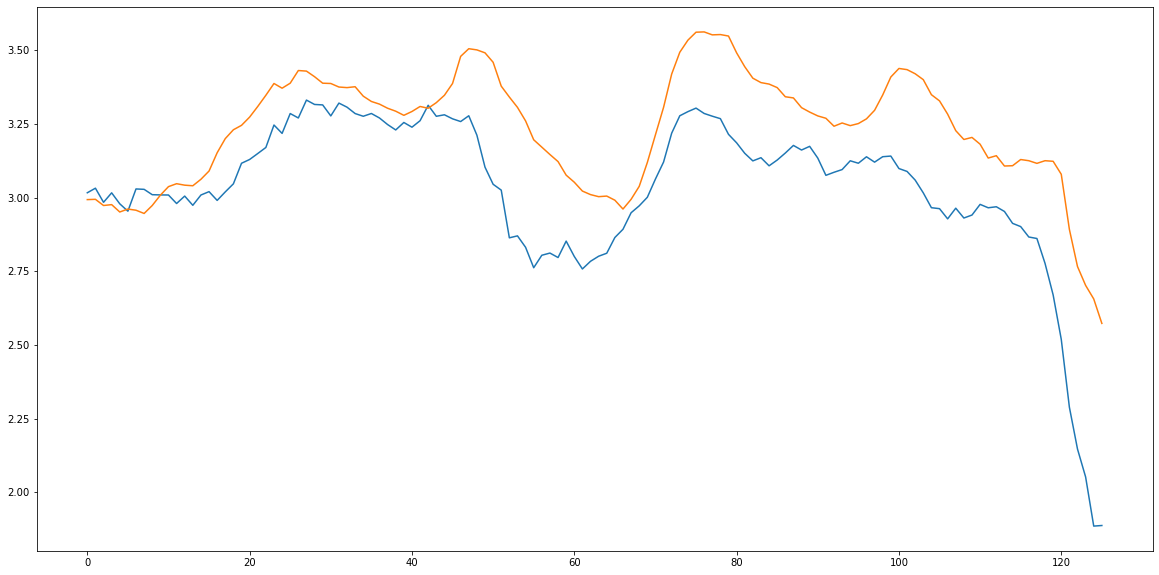

EarlyStopping counter: 50 out of 50
Early stopping


In [103]:
epochs = 200
loss = nn.MSELoss()

# initialize the early_stopping object
patience = config["model"]["patience"]
early_stopping = EarlyStopping(patience=50, verbose=True, path='lstm.pt') 

for i in range(epochs):
    mse_train = 0

    for batch_x, batch_y_h, batch_y in data_train_loader :
         
        batch_x = batch_x.to(device)  
        batch_y = batch_y.to(device)
        batch_y_h = batch_y_h.to(device)
        opt.zero_grad()
        
        h, c = lstm.init_hidden_internal(batch_x.shape[0])
        y_pred, h, c = lstm(batch_x, h, c)
        
        y_pred = y_pred.squeeze(1)        
        l = loss(y_pred, batch_y)
        l.backward()
        mse_train += l.item()*batch_x.shape[0]
        opt.step()
        
    with torch.no_grad():
        mse_val = 0
        preds = []
        true = []
        for batch_x, batch_y_h, batch_y in data_val_loader:
            
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            batch_y_h = batch_y_h.to(device)
            
            h, c = lstm.init_hidden_internal(batch_x.shape[0])
            output, h, c = lstm(batch_x, h, c)
            
            output = output.squeeze(1)
            preds.append(output.detach().cpu().numpy())
            true.append(batch_y.detach().cpu().numpy())
            mse_val += loss(output, batch_y).item()*batch_x.shape[0]
    preds = np.concatenate(preds)
    true = np.concatenate(true)
    
    # Learning rate scheduler
    epoch_scheduler.step(mse_val/len(X_val_t))
    lr = opt.param_groups[0]['lr']
    
    # early_stopping needs the validation loss to check if it has decresed, 
    # and if it has, it will make a checkpoint of the current model
    early_stopping(mse_val/len(X_val_t), lstm)

    if early_stopping.early_stop:
        print("Early stopping")
        break
    
    print("Iter: ", i, "train: ", (mse_train/len(X_train_t))**0.5, 
          "val: ", (mse_val/len(X_val_t))**0.5, 
          "LR: ", lr
         )
    if(i % 10 == 0):
        preds = preds*(target_train_max - target_train_min) + target_train_min
        true = true*(target_train_max - target_train_min) + target_train_min
        mse = mean_squared_error(true, preds)
        mae = mean_absolute_error(true, preds)
        print("mse: ", mse, "mae: ", mae)
        plt.figure(figsize=(20, 10))
        plt.plot(preds)
        plt.plot(true)
        plt.show()

### Evaluation

In [104]:
lstm.load_state_dict(torch.load("lstm.pt"))

<All keys matched successfully>

In [105]:
with torch.no_grad():
    mse_val = 0
    preds = []
    true = []
    for batch_x, batch_y_h, batch_y in data_test_loader:
        h, c = lstm.init_hidden_internal(batch_x.shape[0])
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        batch_y_h = batch_y_h.to(device)
        output, h, c = lstm(batch_x, h, c)
        preds.append(output.detach().cpu().numpy())
        true.append(batch_y.detach().cpu().numpy())
        mse_val += loss(torch.squeeze(output), batch_y).item()*batch_x.shape[0]
preds = np.concatenate(preds)
true = np.concatenate(true)

preds = preds*(target_train_max - target_train_min) + target_train_min
true = true*(target_train_max - target_train_min) + target_train_min

mse = mean_squared_error(true, preds)
mae = mean_absolute_error(true, preds)

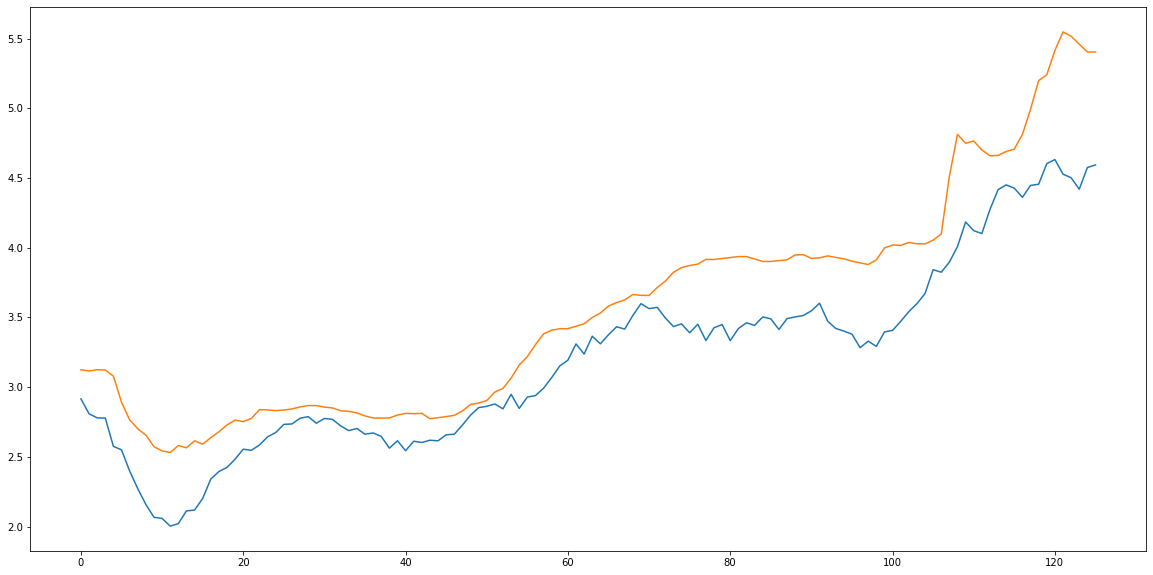

In [106]:
plt.figure(figsize=(20, 10))
plt.plot(preds)
plt.plot(true)
plt.show()

### Forecasting

## 6c. Attentioned-Based Neural Network (DA-RNN)

In [51]:
class InputAttentionEncoder(nn.Module):
    def __init__(self, N, M, T, device, stateful=False):
        """
        :param: N: int
            number of time serieses
        :param: M:
            number of LSTM units
        :param: T:
            number of timesteps
        :param: stateful:
            decides whether to initialize cell state of new time window with values of the last cell state
            of previous time window or to initialize it with zeros
        """
        super(self.__class__, self).__init__()
        self.N = N
        self.M = M
        self.T = T
        
        self.encoder_lstm = nn.LSTMCell(input_size=self.N, hidden_size=self.M)
        
        #equation 8 matrices
        
        self.W_e = nn.Linear(2*self.M, self.T)
        self.U_e = nn.Linear(self.T, self.T, bias=False)
        self.v_e = nn.Linear(self.T, 1, bias=False)
    
    def forward(self, inputs):
        encoded_inputs = torch.zeros((inputs.size(0), self.T, self.M)).to(device)
        
        #initiale hidden states
        h_tm1 = torch.zeros((inputs.size(0), self.M)).to(device)
        s_tm1 = torch.zeros((inputs.size(0), self.M)).to(device)
        
        for t in range(self.T):
            #concatenate hidden states
            h_c_concat = torch.cat((h_tm1, s_tm1), dim=1)
            
            #attention weights for each k in N (equation 8)
            x = self.W_e(h_c_concat).unsqueeze_(1).repeat(1, self.N, 1)
            y = self.U_e(inputs.permute(0, 2, 1))
            z = torch.tanh(x + y)
            e_k_t = torch.squeeze(self.v_e(z))
        
            #normalize attention weights (equation 9)
            alpha_k_t = F.softmax(e_k_t, dim=1)
            
            #weight inputs (equation 10)
            weighted_inputs = alpha_k_t * inputs[:, t, :] 
    
            #calculate next hidden states (equation 11)
            h_tm1, s_tm1 = self.encoder_lstm(weighted_inputs, (h_tm1, s_tm1))
            
            encoded_inputs[:, t, :] = h_tm1
        return encoded_inputs
    
class TemporalAttentionDecoder(nn.Module):
    def __init__(self, M, P, T, device, stateful=False):
        """
        :param: M: int
            number of encoder LSTM units
        :param: P:
            number of deocder LSTM units
        :param: T:
            number of timesteps
        :param: stateful:
            decides whether to initialize cell state of new time window with values of the last cell state
            of previous time window or to initialize it with zeros
        """
        super(self.__class__, self).__init__()
        self.M = M
        self.P = P
        self.T = T
        self.stateful = stateful
        
        self.decoder_lstm = nn.LSTMCell(input_size=1, hidden_size=self.P)
        
        #equation 12 matrices
        self.W_d = nn.Linear(2*self.P, self.M)
        self.U_d = nn.Linear(self.M, self.M, bias=False)
        self.v_d = nn.Linear(self.M, 1, bias = False)
        
        #equation 15 matrix
        self.w_tilda = nn.Linear(self.M + 1, 1)
        
        #equation 22 matrices
        self.W_y = nn.Linear(self.P + self.M, self.P)
        self.v_y = nn.Linear(self.P, 1)
        
    def forward(self, encoded_inputs, y):
        
        #initializing hidden states
        d_tm1 = torch.zeros((encoded_inputs.size(0), self.P)).to(device)
        s_prime_tm1 = torch.zeros((encoded_inputs.size(0), self.P)).to(device)
        for t in range(self.T):
            #concatenate hidden states
            d_s_prime_concat = torch.cat((d_tm1, s_prime_tm1), dim=1)
            #print(d_s_prime_concat)
            #temporal attention weights (equation 12)
            x1 = self.W_d(d_s_prime_concat).unsqueeze_(1).repeat(1, encoded_inputs.shape[1], 1)
            y1 = self.U_d(encoded_inputs)
            z1 = torch.tanh(x1 + y1)
            l_i_t = self.v_d(z1)
            
            #normalized attention weights (equation 13)
            beta_i_t = F.softmax(l_i_t, dim=1)
            
            #create context vector (equation_14)
            c_t = torch.sum(beta_i_t * encoded_inputs, dim=1)
            
            #concatenate c_t and y_t
            y_c_concat = torch.cat((c_t, y[:, t, :]), dim=1)
            #create y_tilda
            y_tilda_t = self.w_tilda(y_c_concat)
            
            #calculate next hidden states (equation 16)
            d_tm1, s_prime_tm1 = self.decoder_lstm(y_tilda_t, (d_tm1, s_prime_tm1))
        
        #concatenate context vector at step T and hidden state at step T
        d_c_concat = torch.cat((d_tm1, c_t), dim=1)

        #calculate output
        y_Tp1 = self.v_y(self.W_y(d_c_concat))
        return y_Tp1
    
class DARNN(nn.Module):
    def __init__(self, N, M, P, T, device, stateful_encoder=False, stateful_decoder=False):
        """
        :param: N: int
            number of time series
        :param: M: int
            number of encoder LSTM units
        :param: P:
            number of deocder LSTM units
        :param: T:
            number of timesteps
        :param: stateful_encoder & stateful_decoder:
            decides whether to initialize cell state of new time window with 
            values of the last cell state of previous time window or to 
            initialize it with zeros
        """
        super(self.__class__, self).__init__()
        self.encoder = InputAttentionEncoder(N, M, T, device, stateful_encoder).to(device)
        self.decoder = TemporalAttentionDecoder(M, P, T, device, stateful_decoder).to(device)
    def forward(self, X_history, y_history):
        out = self.decoder(self.encoder(X_history), y_history)
        return out

### Training

In [52]:
darnn = DARNN(N=X_train.shape[2], M=64, P=16, T=X_train.shape[1], device=device).to(device) # 1) M=64, N=16; 2) M=32, N=32
opt = torch.optim.Adam(darnn.parameters(), lr=0.01)
epoch_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=opt, patience=15)

Validation loss decreased (inf --> 0.031734).  Saving model ...
Iter:  0 train:  0.21309632411977705 val:  0.17813954058619644 LR:  0.01
mse:  0.21139598 mae:  0.43544316


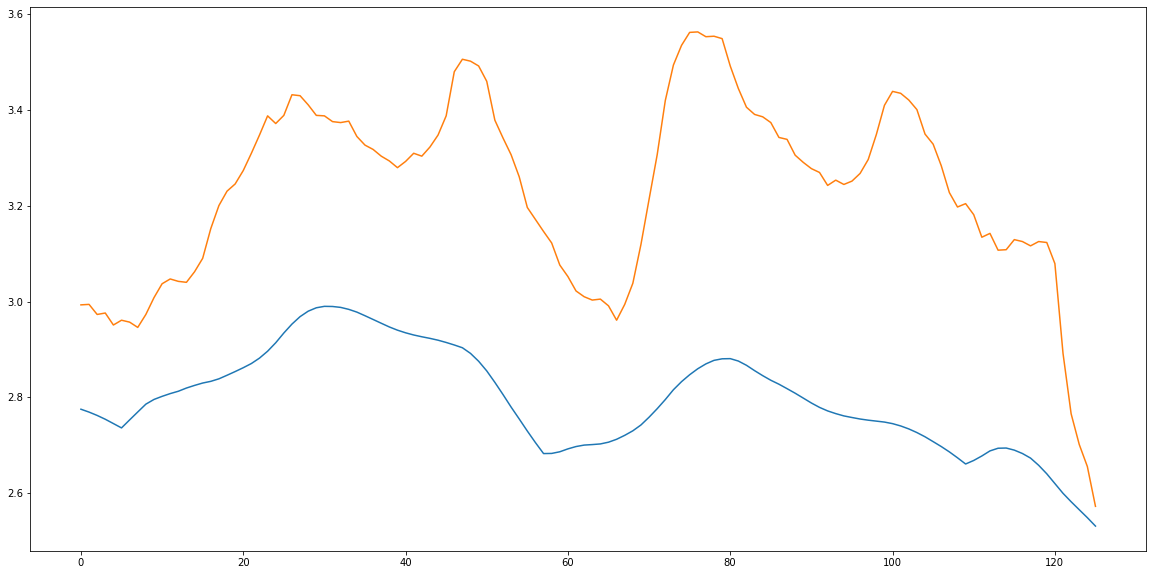

EarlyStopping counter: 1 out of 50
Iter:  1 train:  0.08889373496616694 val:  0.18506303019757045 LR:  0.01
EarlyStopping counter: 2 out of 50
Iter:  2 train:  0.07014722875537524 val:  0.18163228166374357 LR:  0.01
Validation loss decreased (0.031734 --> 0.016436).  Saving model ...
Iter:  3 train:  0.056248654420351714 val:  0.12820178844979177 LR:  0.01
EarlyStopping counter: 1 out of 50
Iter:  4 train:  0.052147290806514944 val:  0.13161036947890367 LR:  0.01
EarlyStopping counter: 2 out of 50
Iter:  5 train:  0.04533193519749432 val:  0.14825672500636217 LR:  0.01
Validation loss decreased (0.016436 --> 0.015847).  Saving model ...
Iter:  6 train:  0.04723775580968265 val:  0.12588614679348742 LR:  0.01
EarlyStopping counter: 1 out of 50
Iter:  7 train:  0.043907857172254976 val:  0.14895060300378585 LR:  0.01
Validation loss decreased (0.015847 --> 0.013899).  Saving model ...
Iter:  8 train:  0.04801972162465575 val:  0.11789540398214934 LR:  0.01
EarlyStopping counter: 1 out of

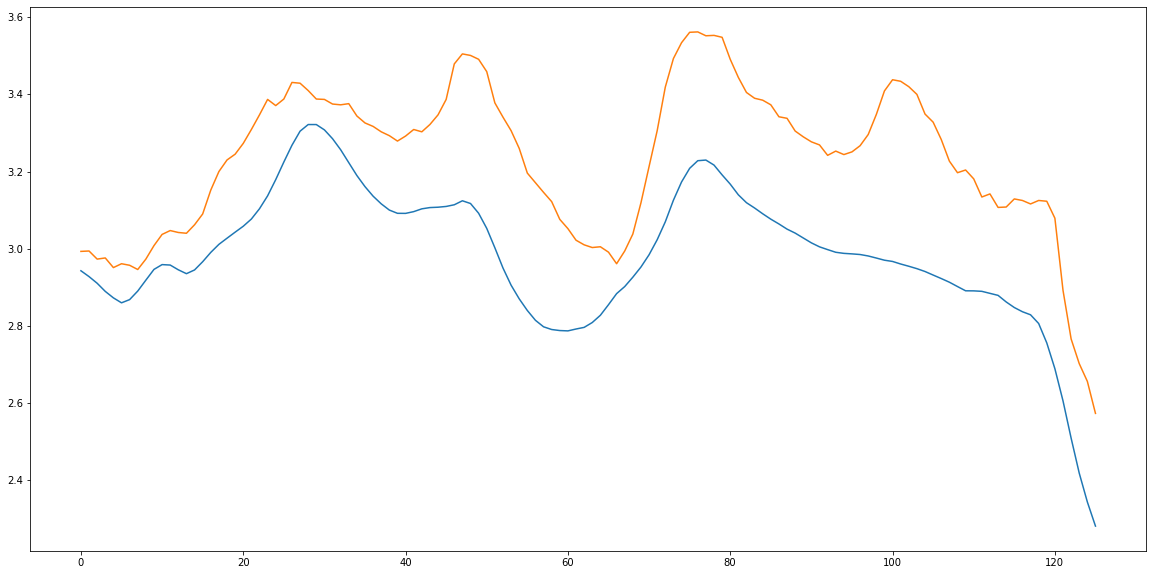

Validation loss decreased (0.010964 --> 0.008102).  Saving model ...
Iter:  11 train:  0.045308564262821795 val:  0.09001053036839828 LR:  0.01
Validation loss decreased (0.008102 --> 0.006124).  Saving model ...
Iter:  12 train:  0.037619282809511816 val:  0.07825489938788473 LR:  0.01
Validation loss decreased (0.006124 --> 0.002244).  Saving model ...
Iter:  13 train:  0.028118170724764198 val:  0.047368055067388365 LR:  0.01
EarlyStopping counter: 1 out of 50
Iter:  14 train:  0.025551729145078216 val:  0.06853440512185105 LR:  0.01
Validation loss decreased (0.002244 --> 0.000521).  Saving model ...
Iter:  15 train:  0.019385371053179848 val:  0.022816494989547437 LR:  0.01
EarlyStopping counter: 1 out of 50
Iter:  16 train:  0.019206302025465753 val:  0.025193221843235584 LR:  0.01
EarlyStopping counter: 2 out of 50
Iter:  17 train:  0.018185186069897503 val:  0.042086975359884864 LR:  0.01
EarlyStopping counter: 3 out of 50
Iter:  18 train:  0.019412642540616927 val:  0.04092352

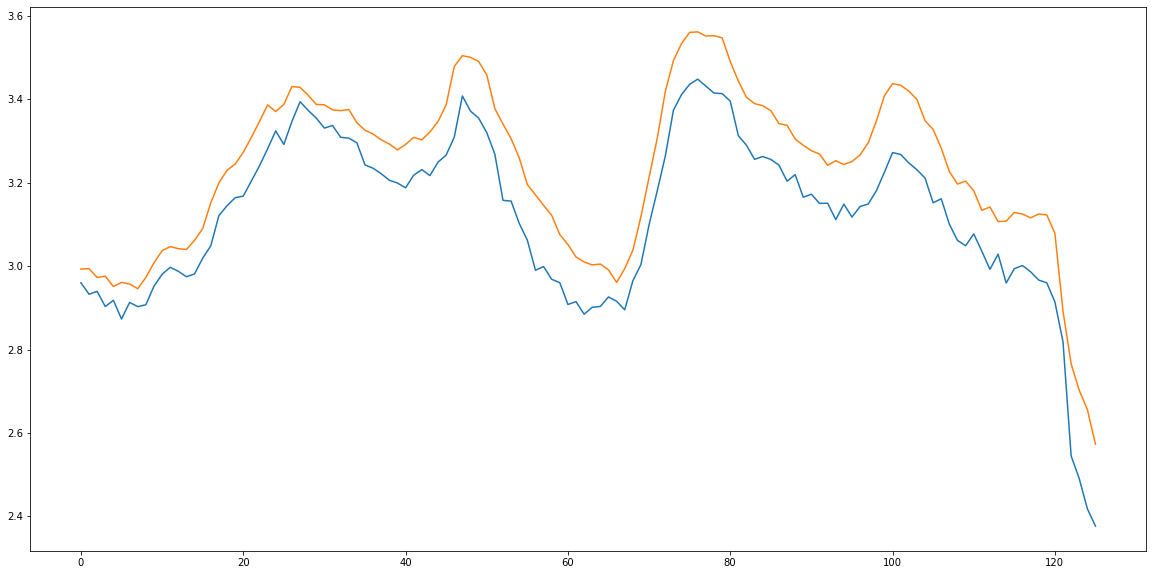

EarlyStopping counter: 6 out of 50
Iter:  21 train:  0.01556166685062738 val:  0.03011829376235773 LR:  0.01
EarlyStopping counter: 7 out of 50
Iter:  22 train:  0.017063430375414048 val:  0.023618626495018523 LR:  0.01
EarlyStopping counter: 8 out of 50
Iter:  23 train:  0.015130262944270365 val:  0.022829182281404122 LR:  0.01
EarlyStopping counter: 9 out of 50
Iter:  24 train:  0.015560658954593826 val:  0.028729156203062062 LR:  0.01
EarlyStopping counter: 10 out of 50
Iter:  25 train:  0.014932766303256967 val:  0.026658627714221936 LR:  0.01
Validation loss decreased (0.000521 --> 0.000504).  Saving model ...
Iter:  26 train:  0.014780039732386651 val:  0.022448842048622894 LR:  0.01
EarlyStopping counter: 1 out of 50
Iter:  27 train:  0.014001298543903981 val:  0.0302882619982758 LR:  0.01
EarlyStopping counter: 2 out of 50
Iter:  28 train:  0.015033583112981018 val:  0.04169097547674833 LR:  0.01
EarlyStopping counter: 3 out of 50
Iter:  29 train:  0.015677734241765197 val:  0.

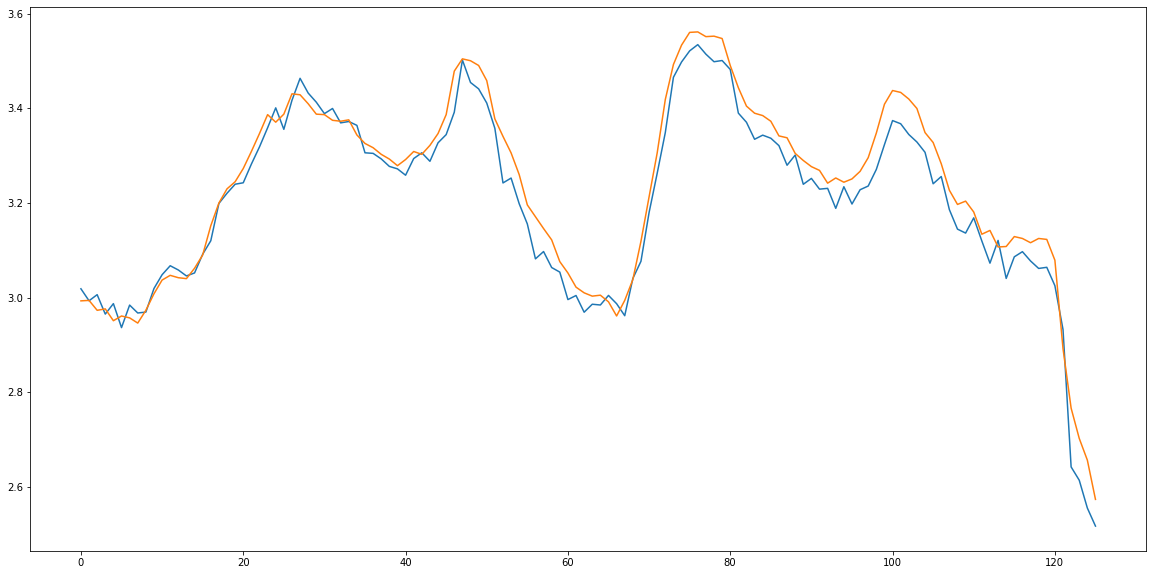

EarlyStopping counter: 1 out of 50
Iter:  31 train:  0.02019669808433382 val:  0.028228374152902535 LR:  0.01
EarlyStopping counter: 2 out of 50
Iter:  32 train:  0.019344790070112066 val:  0.02389538436707906 LR:  0.01
EarlyStopping counter: 3 out of 50
Iter:  33 train:  0.017110452898711125 val:  0.017327316033666842 LR:  0.01
EarlyStopping counter: 4 out of 50
Iter:  34 train:  0.015483202046064827 val:  0.02683560185636673 LR:  0.01
EarlyStopping counter: 5 out of 50
Iter:  35 train:  0.014869899931073072 val:  0.0308303195133993 LR:  0.01
EarlyStopping counter: 6 out of 50
Iter:  36 train:  0.014773630824235044 val:  0.021231111023629443 LR:  0.01
EarlyStopping counter: 7 out of 50
Iter:  37 train:  0.01678052323464132 val:  0.03239270983520974 LR:  0.01
EarlyStopping counter: 8 out of 50
Iter:  38 train:  0.014011225445328322 val:  0.027039524203011218 LR:  0.01
Validation loss decreased (0.000288 --> 0.000213).  Saving model ...
Iter:  39 train:  0.014964103853373191 val:  0.014

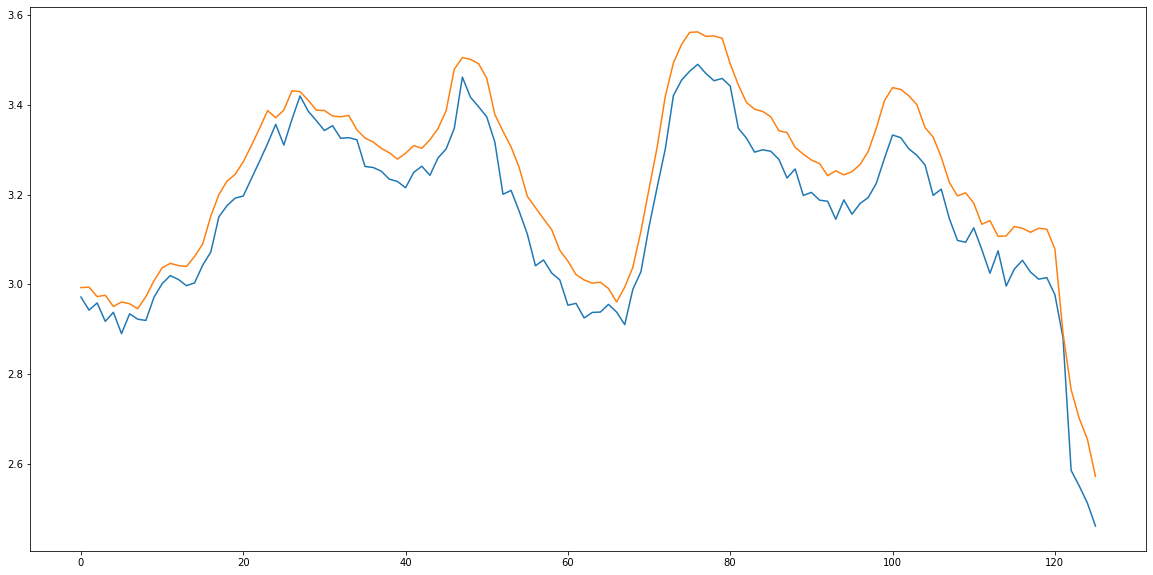

EarlyStopping counter: 2 out of 50
Iter:  41 train:  0.016959017940760608 val:  0.01573670773736775 LR:  0.01
EarlyStopping counter: 3 out of 50
Iter:  42 train:  0.016972120842337807 val:  0.030344831370710285 LR:  0.01
EarlyStopping counter: 4 out of 50
Iter:  43 train:  0.016052250555260574 val:  0.015921826071814763 LR:  0.01
EarlyStopping counter: 5 out of 50
Iter:  44 train:  0.014831340499600942 val:  0.01590416092590499 LR:  0.01
EarlyStopping counter: 6 out of 50
Iter:  45 train:  0.016378963755099393 val:  0.022145843719258682 LR:  0.01
EarlyStopping counter: 7 out of 50
Iter:  46 train:  0.014810930125537405 val:  0.020182972233111766 LR:  0.01
EarlyStopping counter: 8 out of 50
Iter:  47 train:  0.014143733433263302 val:  0.026049749646980123 LR:  0.01
EarlyStopping counter: 9 out of 50
Iter:  48 train:  0.015213041975976034 val:  0.03609175578716716 LR:  0.01
EarlyStopping counter: 10 out of 50
Iter:  49 train:  0.017367284742251344 val:  0.024677037987427233 LR:  0.01
Ear

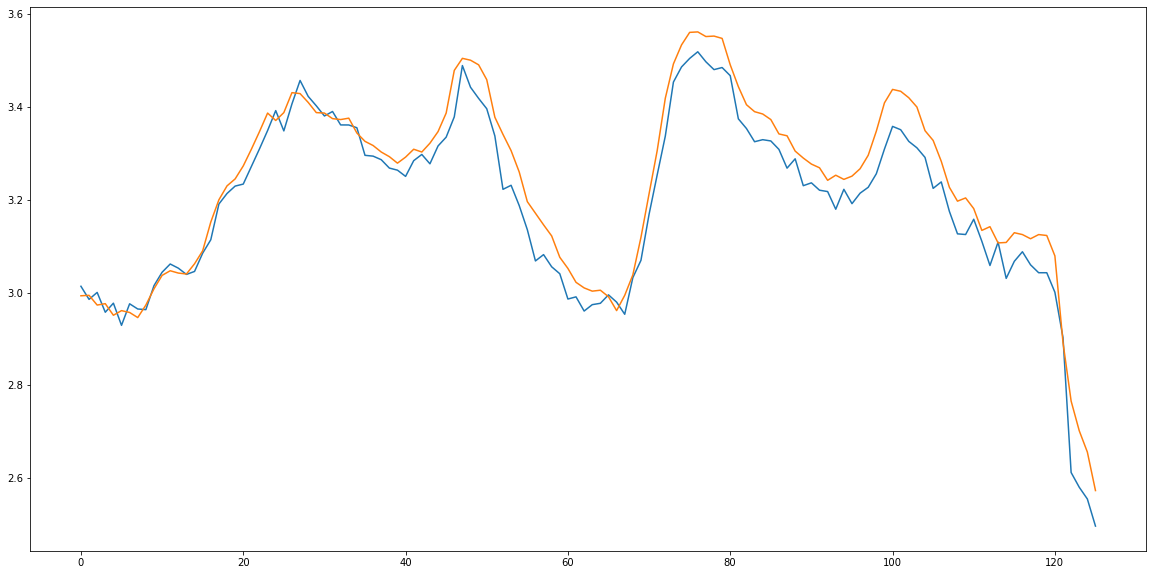

EarlyStopping counter: 12 out of 50
Iter:  51 train:  0.017258936416638716 val:  0.03267530996184371 LR:  0.01
Validation loss decreased (0.000213 --> 0.000206).  Saving model ...
Iter:  52 train:  0.016851932944796862 val:  0.014363668554336023 LR:  0.01
EarlyStopping counter: 1 out of 50
Iter:  53 train:  0.02119127495044444 val:  0.02347260957650271 LR:  0.01
EarlyStopping counter: 2 out of 50
Iter:  54 train:  0.01983313868000454 val:  0.020611012601087178 LR:  0.01
EarlyStopping counter: 3 out of 50
Iter:  55 train:  0.01642176945001737 val:  0.025179764273605607 LR:  0.01
EarlyStopping counter: 4 out of 50
Iter:  56 train:  0.014505194318740072 val:  0.016490258378494375 LR:  0.01
EarlyStopping counter: 5 out of 50
Iter:  57 train:  0.013794458100221622 val:  0.024143904459276243 LR:  0.01
EarlyStopping counter: 6 out of 50
Iter:  58 train:  0.01608839404387532 val:  0.028793016867189332 LR:  0.01
EarlyStopping counter: 7 out of 50
Iter:  59 train:  0.01601073046465518 val:  0.03

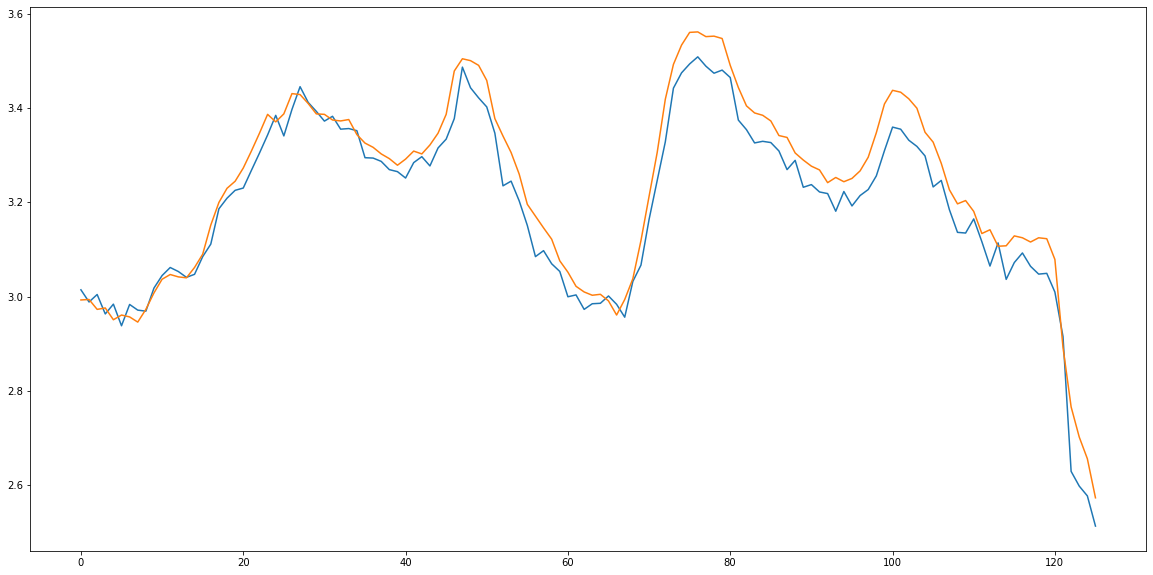

EarlyStopping counter: 9 out of 50
Iter:  61 train:  0.01879972034263931 val:  0.025674327772739522 LR:  0.01
EarlyStopping counter: 10 out of 50
Iter:  62 train:  0.01371905110691961 val:  0.020483641592605784 LR:  0.01
EarlyStopping counter: 11 out of 50
Iter:  63 train:  0.015363981732476854 val:  0.02002818655556637 LR:  0.01
EarlyStopping counter: 12 out of 50
Iter:  64 train:  0.01435184665575244 val:  0.02060659917334045 LR:  0.01
EarlyStopping counter: 13 out of 50
Iter:  65 train:  0.01625341568206717 val:  0.0246490138480609 LR:  0.01
EarlyStopping counter: 14 out of 50
Iter:  66 train:  0.015270492979935471 val:  0.02356214765695671 LR:  0.01
EarlyStopping counter: 15 out of 50
Iter:  67 train:  0.015272205584973405 val:  0.024033453001589548 LR:  0.01
EarlyStopping counter: 16 out of 50
Iter:  68 train:  0.013971164086397052 val:  0.01757687070848094 LR:  0.001
EarlyStopping counter: 17 out of 50
Iter:  69 train:  0.01334146603383292 val:  0.022565644203311815 LR:  0.001
Ea

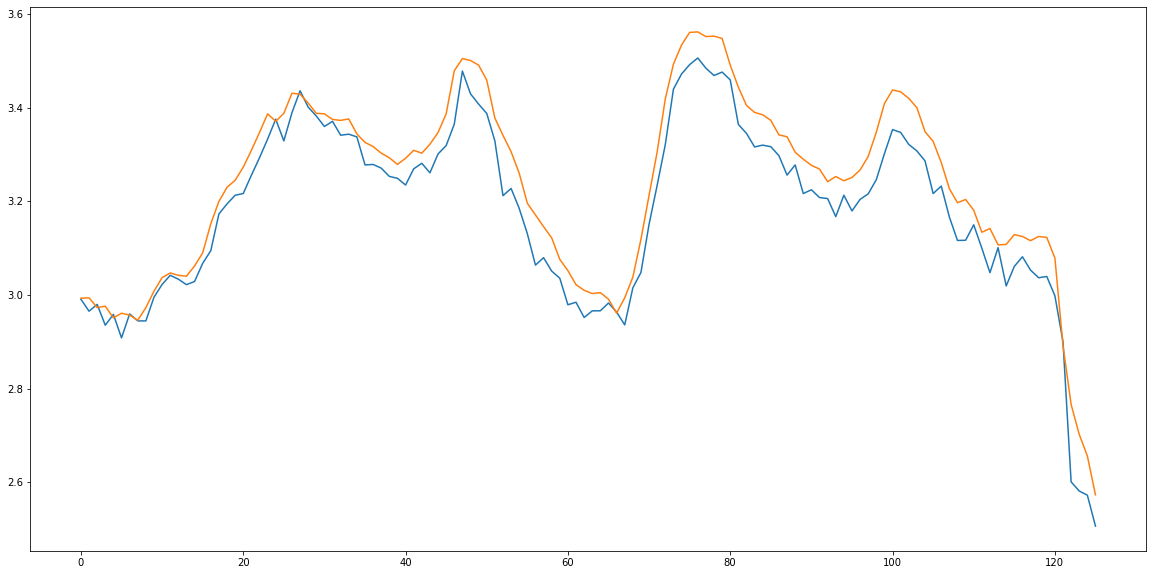

EarlyStopping counter: 19 out of 50
Iter:  71 train:  0.01266523163828111 val:  0.02498099939582385 LR:  0.001
EarlyStopping counter: 20 out of 50
Iter:  72 train:  0.012606105214698345 val:  0.023449004066218776 LR:  0.001
EarlyStopping counter: 21 out of 50
Iter:  73 train:  0.0127458720071607 val:  0.020753489543411413 LR:  0.001
EarlyStopping counter: 22 out of 50
Iter:  74 train:  0.012676354869743797 val:  0.023880255944635456 LR:  0.001
EarlyStopping counter: 23 out of 50
Iter:  75 train:  0.012559135702860103 val:  0.0223789173298941 LR:  0.001
EarlyStopping counter: 24 out of 50
Iter:  76 train:  0.01260641047672089 val:  0.0198179724263053 LR:  0.001
EarlyStopping counter: 25 out of 50
Iter:  77 train:  0.012831295796846946 val:  0.022169108284330614 LR:  0.001
EarlyStopping counter: 26 out of 50
Iter:  78 train:  0.012546196178820926 val:  0.02321204985601522 LR:  0.001
EarlyStopping counter: 27 out of 50
Iter:  79 train:  0.012844033578740878 val:  0.02301869715912241 LR:  

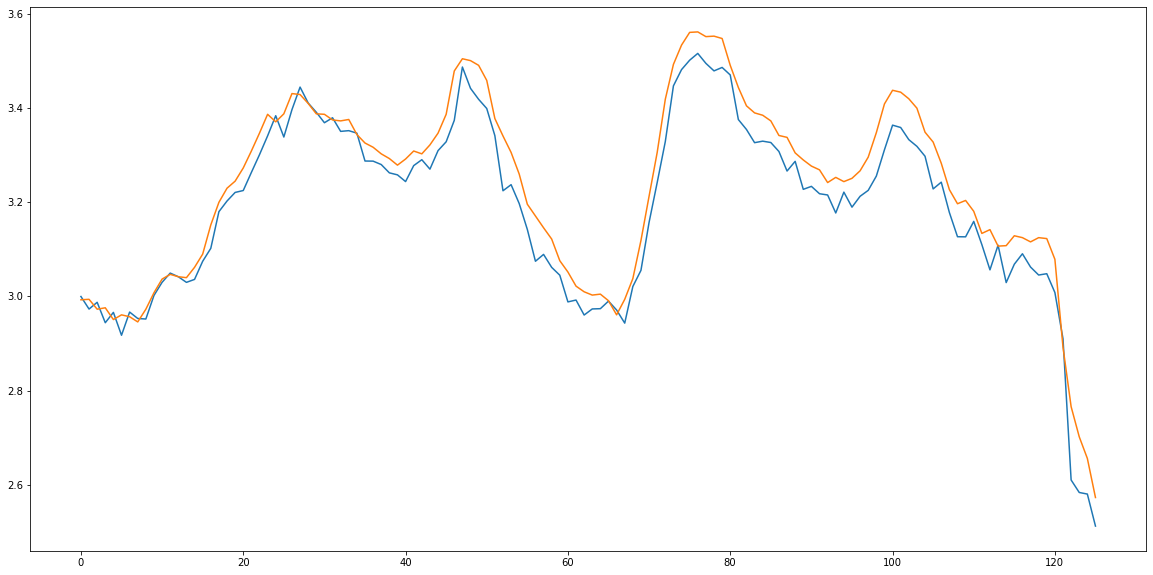

EarlyStopping counter: 29 out of 50
Iter:  81 train:  0.01270433823141437 val:  0.023363171676362312 LR:  0.001
EarlyStopping counter: 30 out of 50
Iter:  82 train:  0.012580226118020238 val:  0.022390940493925926 LR:  0.001
EarlyStopping counter: 31 out of 50
Iter:  83 train:  0.012695507396029544 val:  0.02237953545210132 LR:  0.001
EarlyStopping counter: 32 out of 50
Iter:  84 train:  0.01257550121370461 val:  0.02522889170335673 LR:  0.0001
EarlyStopping counter: 33 out of 50
Iter:  85 train:  0.012605564118092376 val:  0.022658026547594367 LR:  0.0001
EarlyStopping counter: 34 out of 50
Iter:  86 train:  0.012397751184976793 val:  0.02289548384083412 LR:  0.0001
EarlyStopping counter: 35 out of 50
Iter:  87 train:  0.012403427922329695 val:  0.022582114139386565 LR:  0.0001
EarlyStopping counter: 36 out of 50
Iter:  88 train:  0.012386014158115308 val:  0.022372421720669732 LR:  0.0001
EarlyStopping counter: 37 out of 50
Iter:  89 train:  0.01239839382089818 val:  0.02253154258492

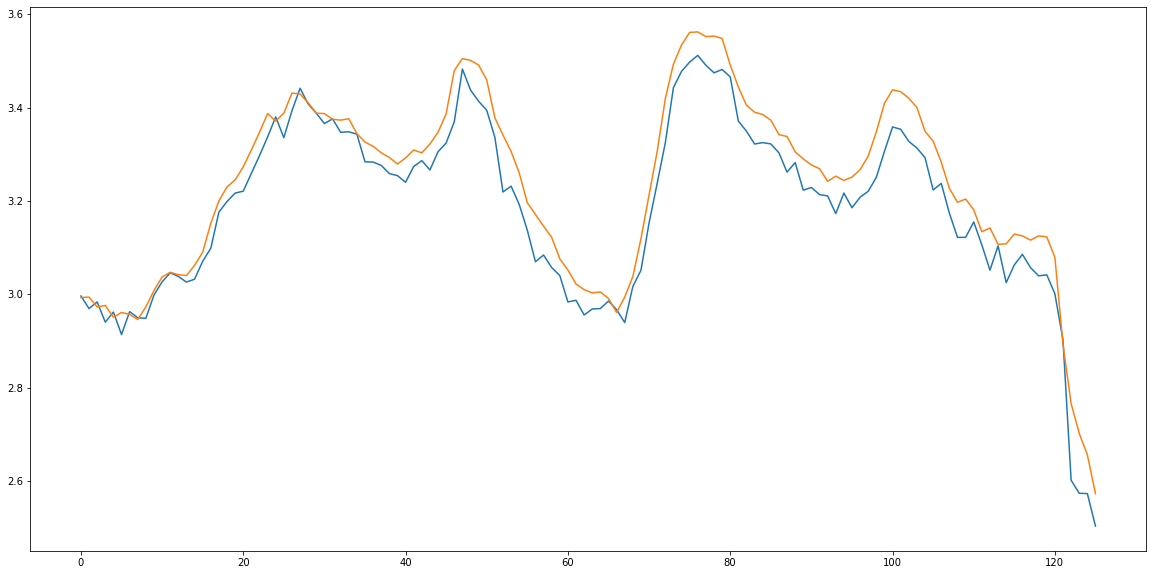

EarlyStopping counter: 39 out of 50
Iter:  91 train:  0.012402150022739469 val:  0.022519733295308382 LR:  0.0001
EarlyStopping counter: 40 out of 50
Iter:  92 train:  0.012384503339804296 val:  0.022261633803829624 LR:  0.0001
EarlyStopping counter: 41 out of 50
Iter:  93 train:  0.012388743433574165 val:  0.022509370718343018 LR:  0.0001
EarlyStopping counter: 42 out of 50
Iter:  94 train:  0.012413696149793247 val:  0.023164367601593516 LR:  0.0001
EarlyStopping counter: 43 out of 50
Iter:  95 train:  0.012405724751865395 val:  0.022242330740518117 LR:  0.0001
EarlyStopping counter: 44 out of 50
Iter:  96 train:  0.012394717283521137 val:  0.0222646831532446 LR:  0.0001
EarlyStopping counter: 45 out of 50
Iter:  97 train:  0.012395745940801377 val:  0.022567811355006087 LR:  0.0001
EarlyStopping counter: 46 out of 50
Iter:  98 train:  0.012411384738069835 val:  0.02275809274946338 LR:  0.0001
EarlyStopping counter: 47 out of 50
Iter:  99 train:  0.012393578408724792 val:  0.02254606

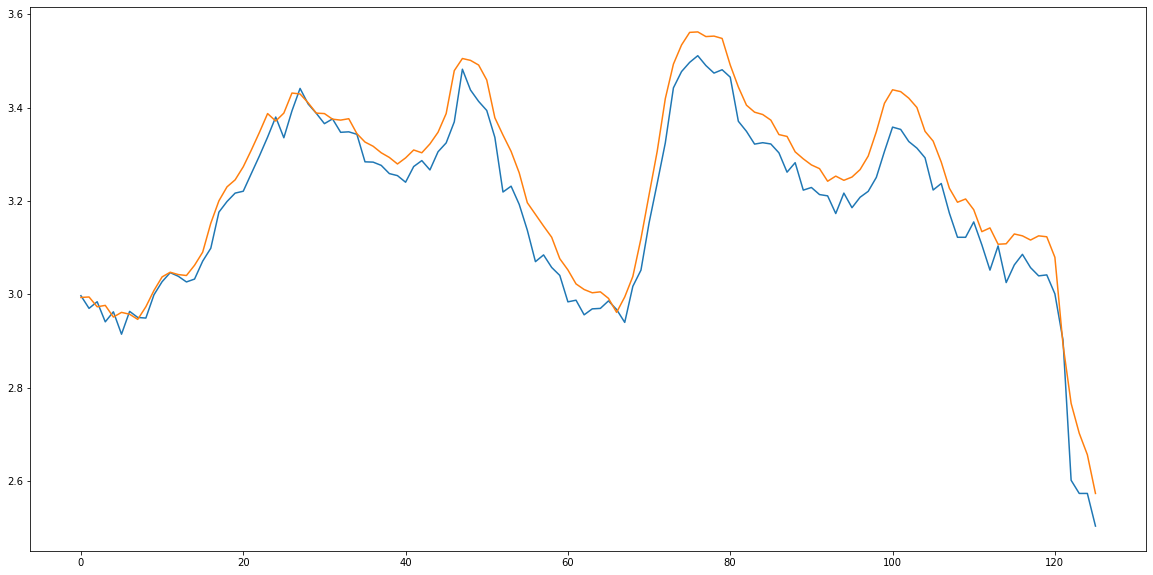

EarlyStopping counter: 49 out of 50
Iter:  101 train:  0.012356692133397944 val:  0.022547381280177883 LR:  1e-05
EarlyStopping counter: 50 out of 50
Early stopping


In [53]:
epochs = 1000
loss = nn.MSELoss()

# initialize the early_stopping object
patience = config["model"]["patience"]
early_stopping = EarlyStopping(patience=50, verbose=True, path='darnn.pt') 

for i in range(epochs):
    mse_train = 0
    for batch_x, batch_y_h, batch_y in data_train_loader :
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        batch_y_h = batch_y_h.to(device)
        opt.zero_grad()
        y_pred = darnn(batch_x, batch_y_h)
        y_pred = y_pred.squeeze(1)
        l = loss(y_pred, batch_y)
        l.backward()
        mse_train += l.item()*batch_x.shape[0]
        opt.step()
    with torch.no_grad():
        mse_val = 0
        preds = []
        true = []
        for batch_x, batch_y_h, batch_y in data_val_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            batch_y_h = batch_y_h.to(device)
            output = darnn(batch_x, batch_y_h)
            output = output.squeeze(1)
            preds.append(output.detach().cpu().numpy())
            true.append(batch_y.detach().cpu().numpy())
            mse_val += loss(output, batch_y).item()*batch_x.shape[0]
    preds = np.concatenate(preds)
    true = np.concatenate(true)
    
    # Learning rate scheduler
    epoch_scheduler.step(mse_val/len(X_val_t))
    lr = opt.param_groups[0]['lr']
    
    # early_stopping needs the validation loss to check if it has decresed, 
    # and if it has, it will make a checkpoint of the current model
    early_stopping(mse_val/len(X_val_t), darnn)

    if early_stopping.early_stop:
        print("Early stopping")
        break
    
    print("Iter: ", i, "train: ", (mse_train/len(X_train_t))**0.5, 
          "val: ", (mse_val/len(X_val_t))**0.5, 
          "LR: ", lr
         )
    if(i % 10 == 0):
        preds = preds*(target_train_max - target_train_min) + target_train_min
        true = true*(target_train_max - target_train_min) + target_train_min
        mse = mean_squared_error(true, preds)
        mae = mean_absolute_error(true, preds)
        print("mse: ", mse, "mae: ", mae)
        plt.figure(figsize=(20, 10))
        plt.plot(preds)
        plt.plot(true)
        plt.show()

### Evaluation

In [54]:
darnn.load_state_dict(torch.load("darnn.pt"))

<All keys matched successfully>

In [55]:
with torch.no_grad():
    mse_val = 0
    preds = []
    true = []
    for batch_x, batch_y_h, batch_y in data_test_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        batch_y_h = batch_y_h.to(device)
        output = darnn(batch_x, batch_y_h)
        preds.append(output.detach().cpu().numpy())
        true.append(batch_y.detach().cpu().numpy())
        mse_val += loss(torch.squeeze(output), batch_y).item()*batch_x.shape[0]
preds = np.concatenate(preds)
true = np.concatenate(true)

In [56]:
preds = preds*(target_train_max - target_train_min) + target_train_min
true = true*(target_train_max - target_train_min) + target_train_min

mse = mean_squared_error(true, preds)
mae = mean_absolute_error(true, preds)

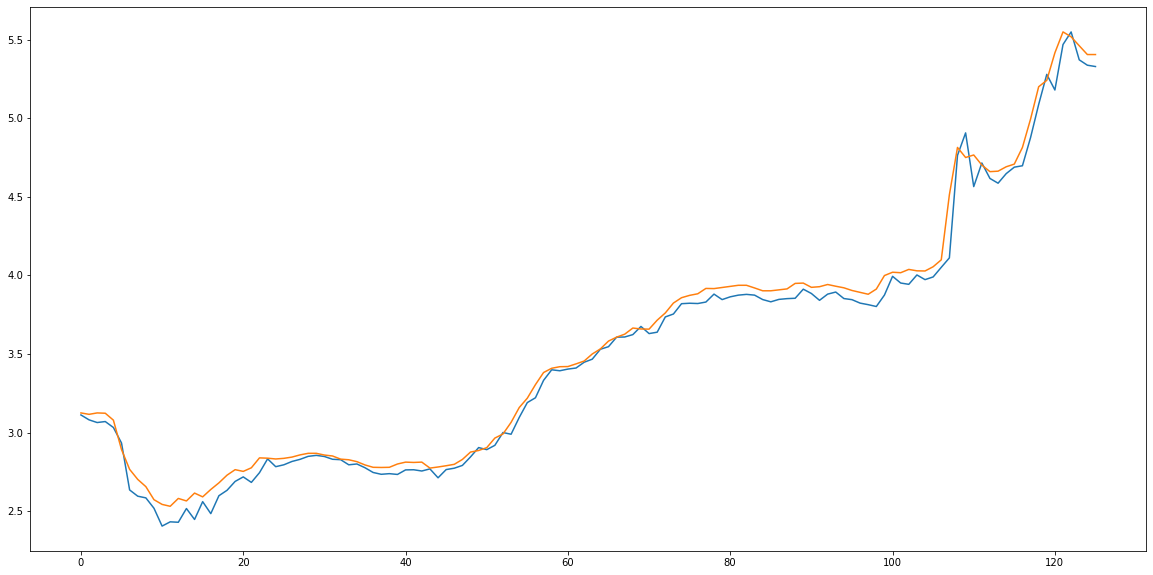

In [57]:
plt.figure(figsize=(20, 10))
plt.plot(preds)
plt.plot(true)
plt.show()

### Forecasting

# 8. Model Evaluation

In [58]:
# # here we re-initialize dataloader so the data doesn't shuffled, so we can plot the values by date

# train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=False)
# val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=False)

# model.eval()

# # predict on the training data, to see how well the model managed to learn and memorize

# predicted_train = np.array([])

# for idx, (x, y) in enumerate(train_dataloader):
#     x = x.to(config["training"]["device"])
#     out = model(x)
#     out = out.cpu().detach().numpy()
#     predicted_train = np.concatenate((predicted_train, out))

# # predict on the validation data, to see how the model does

# predicted_val = np.array([])

# for idx, (x, y) in enumerate(val_dataloader):
#     x = x.to(config["training"]["device"])
#     out = model(x)
#     out = out.cpu().detach().numpy()
#     predicted_val = np.concatenate((predicted_val, out))

# # prepare data for plotting

# to_plot_data_y_train_pred = np.zeros(num_data_points)
# to_plot_data_y_val_pred = np.zeros(num_data_points)

# to_plot_data_y_train_pred[config["data"]["window_size"]:split_index+config["data"]["window_size"]] = scaler.inverse_transform_y(predicted_train)
# to_plot_data_y_val_pred[split_index+config["data"]["window_size"]:] = scaler.inverse_transform_y(predicted_val)

# to_plot_data_y_train_pred = np.where(to_plot_data_y_train_pred == 0, None, to_plot_data_y_train_pred)
# to_plot_data_y_val_pred = np.where(to_plot_data_y_val_pred == 0, None, to_plot_data_y_val_pred)

# # plots

# fig = figure(figsize=(25, 5), dpi=80)
# fig.patch.set_facecolor((1.0, 1.0, 1.0))
# plt.plot(data_date, data_price, label="Actual prices", color=config["plots"]["color_actual"])
# plt.plot(data_date, to_plot_data_y_train_pred, label="Predicted prices (train)", color=config["plots"]["color_pred_train"])
# plt.plot(data_date, to_plot_data_y_val_pred, label="Predicted prices (validation)", color=config["plots"]["color_pred_val"])
# plt.title("Compare predicted prices to actual prices")
# # xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
# # x = np.arange(0,len(xticks))
# # plt.xticks(x, xticks, rotation='vertical')

# # Format the x axis
# locator = mdate.MonthLocator(interval=config["plots"]["xticks_interval"])
# fmt = mdate.DateFormatter('%Y-%m')
# X = plt.gca().xaxis
# X.set_major_locator(locator)
# # Specify formatter
# X.set_major_formatter(fmt)
# plt.xticks(rotation='vertical')
# plt.xlim([data_date[0], data_date[-1]])

# plt.grid(visible=None, which='major', axis='y', linestyle='--')
# plt.legend()
# plt.show()

In [59]:
# # prepare data for plotting the zoomed in view of the predicted prices (on validation set) vs. actual prices

# to_plot_data_y_val_subset = scaler.inverse_transform_y(data_y_val)
# to_plot_predicted_val = scaler.inverse_transform_y(predicted_val)
# to_plot_data_date = data_date[split_index+config["data"]["window_size"]:]

# # plots

# fig = figure(figsize=(25, 5), dpi=80)
# fig.patch.set_facecolor((1.0, 1.0, 1.0))
# plt.plot(to_plot_data_date, to_plot_data_y_val_subset, label="Actual prices", color=config["plots"]["color_actual"])
# plt.plot(to_plot_data_date, to_plot_predicted_val, label="Predicted prices (validation)", color=config["plots"]["color_pred_val"])
# plt.title("Zoom in to examine predicted price on validation data portion")
# # xticks = [to_plot_data_date[i] if ((i%int(config["plots"]["xticks_interval"]/5)==0 and (len(to_plot_data_date)-i) > config["plots"]["xticks_interval"]/6) or i==len(to_plot_data_date)-1) else None for i in range(len(to_plot_data_date))] # make x ticks nice
# # xs = np.arange(0,len(xticks))
# # plt.xticks(xs, xticks, rotation='vertical')

# # Format the x axis
# locator = mdate.MonthLocator(interval=config["plots"]["xticks_interval"])
# fmt = mdate.DateFormatter('%Y-%m')
# X = plt.gca().xaxis
# X.set_major_locator(locator)
# # Specify formatter
# X.set_major_formatter(fmt)
# plt.xticks(rotation='vertical')

# plt.grid(visible=None, which='major', axis='y', linestyle='--')
# plt.legend()
# plt.show()

WARNING - (py.warnings._showwarnmsg) - C:\Users\cpras\anaconda3\envs\GasPrice\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)



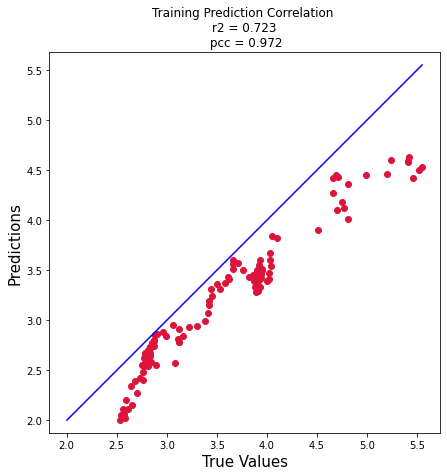

In [107]:
# Distrubution Suitcases between predicted and actual values

true_value = true
predicted_value = preds

r2 = r2_score(true_value, predicted_value)
pcc, _ = PCC(true_value, predicted_value)

plt.figure(figsize=(7,7))
plt.scatter(true_value, predicted_value, c='crimson')
# plt.yscale('log')
# plt.xscale('log')

p1 = max(max(predicted_value), max(true_value))
p2 = min(min(predicted_value), min(true_value))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.title(f'Training Prediction Correlation \n r2 = {r2:.3f} \n pcc = {pcc[0]:.3f}')
plt.show()

Text(0.5, 1.0, 'Training Prediction Correlation \n R2 = 0.723 \n PCC = 0.972')

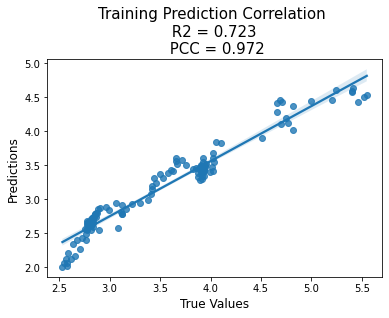

In [108]:
# Distrubution Suitcases between predicted and actual values

ax = sns.regplot(x=true, y=preds)
ax.set_xlabel('True Values', fontsize=12)
ax.set_ylabel('Predictions', fontsize=12)
ax.set_title(f'Training Prediction Correlation \n R2 = {r2:.3f} \n PCC = {pcc[0]:.3f}', fontsize=15)

# 9. Forecasting Future Stock Prices

In [62]:
# # predict the closing price of the next trading day

# model.eval()

# # x = torch.tensor(data_x_unseen).float().to(config["training"]["device"]).unsqueeze(0).unsqueeze(2) # this is the data type and shape required, [batch, sequence, feature]
# x = torch.tensor(data_x_unseen).float().to(config["training"]["device"]).unsqueeze(0)
# prediction = model(x)
# prediction = prediction.cpu().detach().numpy()

# # prepare plots

# plot_range = 10
# to_plot_data_y_val = np.zeros(plot_range)
# to_plot_data_y_val_pred = np.zeros(plot_range)
# to_plot_data_y_test_pred = np.zeros(plot_range)

# to_plot_data_y_val[:plot_range-1] = scaler.inverse_transform_y(data_y_val)[-plot_range+1:]
# to_plot_data_y_val_pred[:plot_range-1] = scaler.inverse_transform_y(predicted_val)[-plot_range+1:]

# to_plot_data_y_test_pred[plot_range-1] = scaler.inverse_transform_y(prediction)

# to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)
# to_plot_data_y_val_pred = np.where(to_plot_data_y_val_pred == 0, None, to_plot_data_y_val_pred)
# to_plot_data_y_test_pred = np.where(to_plot_data_y_test_pred == 0, None, to_plot_data_y_test_pred)

# # plot
# plot_date_test = data_date[-plot_range+1:]
# # for i in range(len(plot_date_test)):
# #     plot_date_test[i] = plot_date_test[i].strftime('%m/%d/%Y')
# next_week = plot_date_test[-1] + dt.timedelta(days=7)
# plot_date_test.append(next_week)

# print(len(plot_date_test) ,  len(to_plot_data_y_val))

# fig = figure(figsize=(25, 5), dpi=80)
# fig.patch.set_facecolor((1.0, 1.0, 1.0))
# plt.plot(plot_date_test, to_plot_data_y_val, label="Actual prices", marker=".", markersize=10, color=config["plots"]["color_actual"])
# plt.plot(plot_date_test, to_plot_data_y_val_pred, label="Past predicted prices", marker=".", markersize=10, color=config["plots"]["color_pred_val"])
# plt.plot(plot_date_test, to_plot_data_y_test_pred, label="Predicted price for next week", marker=".", markersize=20, color=config["plots"]["color_pred_test"])
# plt.title("Predicted Seattle gas price of the next week")
# plt.grid(visible=None, which='major', axis='y', linestyle='--')
# plt.legend()
# plt.show()

# print("Predicted Seattle gas price of the next week:", round(to_plot_data_y_test_pred[plot_range-1], 2))